제가 소름돋는 사실을 발견했습니다. -lag 모델과 lag 모델의 성능 차이가 왜 그렇게 나는지 계속 의아했는데, 이제야 진실을 발견했습니다. 그 이유는 아래와 같습니다.

- base model 에서 target 값은 미래가 아니라 과거를 예측하는 것이었다.(충격)(더욱 충격적인 사실, base model은 잘 했는데, 내가 베끼면서 오류 만듦)
- 그렇기 때문에 lag model을 쓰면 학습데이터에 타겟값이 존재해서 오버피팅 되고 있었다. 그래서 모든 분위수의 결과값이 균등하게 나오는 것이었다.(홀리슅)
- -lag model은 오히려 자기참조의 순환에 걸리지 않아 결과가 잘 나오는 것이었다.
- 즉 target값을 -lag을 주는 게 맞으며, 역으로 lag 모델을 쓰는 게 맞다.
- 그래야만 t ~ t-n -> t+1, t+2 를 예측하는 모델이 된다. t시점의 변수에 가중치를 주며...
- 그래야만 테스트 데이터에도 동일하게 들어간다.

그래서 처음부터 다시 시작하겠습니다. 베이스 코드 올린 친구 밉습니다.

지금 쓸만한 파생변수는 GHI, NEW_GHI, AVGVAR시리즈 등입니다. MABB는 테스트를 다시 해봐야겠습니다. 그래서 지금 테스트 해야할 사항은 다음과 같습니다.

1. 제대로 미래 시점을 예측하는 shift model
2. 1번 모델에 GHI, NEW_GHI, AVGVAR시리즈를 모두 넣은 모델
3. 2번 모델에 MABB를 추가한 모델

In [1]:
# load_dtypes()
# DF 불러올 때부터 축소해서 가져오는 함수.

def load_dtypes(file_path):
    print(file_path)
    tmp = pd.read_csv(file_path, nrows=0) # 애초에 파일을 불러올 때
    col_dtypes= {}
    for col in tmp.columns:
        df = pd.read_csv(file_path, usecols=[col]) # 애초에 파일을 불러올 때
        
        dtype = df[col].dtype
        
        if (dtype == 'int8' or dtype == 'int16' or dtype == 'int32' or dtype == 'int64'):
            c_min = df[col].min()
            c_max = df[col].max()
            dtype = 'int'
            
        elif dtype == 'float32' or dtype == 'float64':
            c_min = df[col].min()
            c_max = df[col].max()
            dtype = 'float'
            
        elif dtype == 'object':
            n_unique = df[col].nunique()
            threshold = n_unique / df.shape[0]
            
        if dtype == 'int':
            if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                col_dtype = 'int8'
            elif c_min > np.iinfo(np.uint8).min and c_max < np.iinfo(np.uint8).max:
                col_dtype = 'uint8'
            elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                col_dtype = 'int16'
            elif c_min > np.iinfo(np.uint16).min and c_max < np.iinfo(np.uint16).max:
                col_dtype = 'uint16'
            elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                col_dtype = 'int32'
            elif c_min > np.iinfo(np.uint32).min and c_max < np.iinfo(np.uint32).max:
                col_dtype = 'uint32'
            elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                col_dtype = 'int64'
            elif c_min > np.iinfo(np.uint64).min and c_max < np.iinfo(np.uint64).max:
                col_dtype = 'uint64'
                
        elif dtype == 'float':
            if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                col_dtype = 'float32'
            else:
                col_dtype = 'float64'
                
        elif dtype == 'object':
            if threshold > 0.7:
                col_dtype = 'object'
            else:
                col_dtype = 'category'
                
        col_dtypes[col] = col_dtype
        

    df = pd.read_csv(file_path, dtype=col_dtypes)
    
    return df

# import

In [78]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import os, sys
import glob
import random
import math
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm
from lightgbm import LGBMRegressor

import matplotlib.pyplot as plt
import seaborn as sns

In [42]:
TRAIN_PATH = r'C:\Users\Wyatt\wyatt37\Data\solarpanel\train\train.csv'
TEST_PATH = r'C:\Users\Wyatt\wyatt37\Data\solarpanel\test'
SUBMISSION_PATH = r'C:\Users\Wyatt\wyatt37\Data\solarpanel\sample_submission.csv'

In [162]:
train = load_dtypes(TRAIN_PATH)
train.info()

C:\Users\Wyatt\wyatt37\Data\solarpanel\train\train.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52560 entries, 0 to 52559
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Day     52560 non-null  int16  
 1   Hour    52560 non-null  int8   
 2   Minute  52560 non-null  int8   
 3   DHI     52560 non-null  int16  
 4   DNI     52560 non-null  int16  
 5   WS      52560 non-null  float32
 6   RH      52560 non-null  float32
 7   T       52560 non-null  int8   
 8   TARGET  52560 non-null  float32
dtypes: float32(3), int16(3), int8(3)
memory usage: 1.1 MB


In [163]:
submission = pd.read_csv(SUBMISSION_PATH)

# preprocessing

In [130]:
# hour와 minute을 합쳐주는 함수입니다.
def sum_hour_minute(train):
    # 0과 30으로 되어 있는 minute을 0과 0.5로 바꿉니다.
    train.Minute = round(train.Minute * 0.017, 1)
    # hour에 minute을 더해줍니다.
    train.Hour = train.Hour + train.Minute
    
    return train

# DHI의 값에 따라서 0~180의 값을 가지는 정규화 함수입니다.
def angle_normalizor(list_, lags=48):
    min_ = min(list_)
    max_ = max(list_)
    return ((list_ - min_) / (max_ - min_))*180

# 천정각에 의해 GHI를 출력하는 함수입니다.
def ghi_formula(DHI, DNI, theta):
    return (DHI + (DNI*np.cos((np.abs(theta-90)-1)*0.0174533)))

# 하루 단위로(48개 index) DHI에 따른 천정각으로 GHI를 만들어주는 함수입니다.
def make_GHI(train, start_window=0, window=48):
    
    end_window = train.shape[0] / window
    #stride = window
    DHI = train.DHI # DHI value 값을 받습니다.
    DNI = train.DNI # DNI value 값을 받습니다.
    GHI = []
    
    #for i in tqdm(range(3)): # 테스트용 코드
    for i in range(np.int(end_window)):
        #print(i)
        if i == 0:
            #print(start_window)
            dhi_window = DHI[start_window:window] # 0부터 window=48 까지를 슬라이싱 해서 받습니다.
            dni_window = DNI[start_window:window]
            # 정규화 시키고,
            dhi_normal = angle_normalizor(dhi_window)
            # GHI 만들고
            new_GHI = ghi_formula(dhi_window, dni_window, dhi_normal)
            # 리스트에 더해줍니다.
            GHI = GHI + list(new_GHI)
        else:
            #print(window)
            dhi_window = DHI[(window*i):(window*(i+1))] # window*i 부터 window*(i+1) 까지를 슬라이싱
            dni_window = DNI[(window*i):(window*(i+1))]
            # 정규화 시키고,
            dhi_normal = angle_normalizor(dhi_window)
            # GHI 만들고
            new_GHI = ghi_formula(dhi_window, dni_window, dhi_normal)
            # 리스트에 더해줍니다.
            GHI = GHI + list(new_GHI)

            #window += stride # 윈도우를 옆으로 stride 시켜준다.
            
            
    train['GHI'] = GHI
    return train

# # 시간에 따른 천정각 추가 함수
# def time_sun_angle(train):
    
#     one_radial = 6.17
#     renew_radial = 0
#     angle = []

#     for i in range(48):
#         if (i/2) > 19.1:
#             angle.append(1)

#         elif (i/2) > 4.9:
#             renew_radial += one_radial
#             angle.append(renew_radial)
#         else:
#             angle.append(1)

#         i += 0.5
        
#     train['ANGLE'] = angle*(int(train.shape[0]/48))
    
#     return train

# # sun_angle 에 따른 GHI 만드는 함수
# def sun_angle_ghi(train):
#     train['NEW_GHI'] = train['DHI'] + (train['DNI']*(np.cos((train['ANGLE'] - 90)*0.0174533)))
    
#     return train

# # 총 일사량 만들기
# def total_irradiance(train):
#     train['TI'] = train.DHI + train.DNI
    
#     return train

# 하루 단위로 평균 기온, 분산 기온, 평균 습도, 분산 습도, 평균 풍속, 
def make_AVGVAR(train, start_window=0, window=48):
    
    end_window = train.shape[0] / window
    #stride = window
    RH = train['RH'] # DHI value 값을 받습니다.
    TP = train['T'] # DNI value 값을 받습니다.
    
    RH_AVG = []
    TP_AVG = []
    RH_VAR = []
    TP_VAR = []
    
    #for i in tqdm(range(3)): # 테스트용 코드
    for i in range(np.int(end_window)):
        #print(i)
        if i == 0:
            #print(start_window)
            rh_window = RH[start_window:window] # 0부터 window=48 까지를 슬라이싱 해서 받습니다.
            tp_window = TP[start_window:window]
            # 평균을 뽑아줍니다.
            rh_avg = rh_window.mean()
            tp_avg = tp_window.mean()
            # 분산을 뽑아줍니다.
            rh_var = rh_window.var()
            tp_var = tp_window.var()
            # 리스트로 만들어줍니다.
            rh_avg_list = [rh_avg]*48
            tp_avg_list = [tp_avg]*48
            rh_var_list = [rh_var]*48
            tp_var_list = [tp_var]*48
            
            # 리스트에 더해줍니다.
            RH_AVG = RH_AVG + rh_avg_list
            TP_AVG = TP_AVG + tp_avg_list
            RH_VAR = RH_VAR + rh_var_list
            TP_VAR = TP_VAR + tp_var_list
        else:
            #print(window)
            rh_window = RH[(window*i):(window*(i+1))] # window*i 부터 window*(i+1) 까지를 슬라이싱
            tp_window = TP[(window*i):(window*(i+1))]
            # 평균을 뽑아줍니다.
            rh_avg = rh_window.mean()
            tp_avg = tp_window.mean()
            # 분산을 뽑아줍니다.
            rh_var = rh_window.var()
            tp_var = tp_window.var()
            # 리스트로 만들어줍니다.
            rh_avg_list = [rh_avg]*48
            tp_avg_list = [tp_avg]*48
            rh_var_list = [rh_var]*48
            tp_var_list = [tp_var]*48
            
            # 리스트에 더해줍니다.
            RH_AVG = RH_AVG + rh_avg_list
            TP_AVG = TP_AVG + tp_avg_list
            RH_VAR = RH_VAR + rh_var_list
            TP_VAR = TP_VAR + tp_var_list
            
    train['RH_AVG'] = RH_AVG
    train['TP_AVG'] = TP_AVG
    train['RH_VAR'] = RH_VAR
    train['TP_VAR'] = TP_VAR
    
    return train

## RH, T 의 표준 점수를 만드는 함수입니다.
#def make_standard_score(train):
#    rh_scores = []
#    tp_scores = []
#    train.reset_index(drop=True, inplace=True)
#    
#    for i in range(len(train)):
#        rh_score = ((train.RH[i] - train.RH_AVG[i])/np.sqrt(train.RH_VAR[i])) *10+50
#        tp_score = ((train['T'][i] - train.TP_AVG[i])/np.sqrt(train.TP_VAR[i])) *10+50
#        
#        rh_scores.append(rh_score)
#        tp_scores.append(tp_score)
#        
#    train['RH_STC'] = rh_scores
#    train['TP_STC'] = tp_scores
#    
#    return train

# 최종적으로 파생변수 만드는 함수
def make_features(train):
    print("original_shape: ", train.shape)
    # hour와 minute 합쳐줍니다.
    train = sum_hour_minute(train)
    
    #-------------------- 파생변수 생성하면 이 아래에 추가
    new_train = make_GHI(train, start_window=0, window=48)
    # 일단 sun_angle을 만듭니다.
    #new_train = time_sun_angle(new_train)
    # new_ghi 만듭니다.
    #new_train = sun_angle_ghi(new_train)
    # total irradiance 만듭니다.
    #new_train = total_irradiance(new_train)
    # AVG, VAR을 만듭니다.
    new_train = make_AVGVAR(new_train)
    # STC를 만듭니다.
    #new_train = make_standard_score(new_train)
    # 필요 없는 column 을 지워줍니다.
    new_train.drop(['Day', 'Minute'], axis=1, inplace=True)  
    
    print("feature_creationed: ", new_train.shape)
    
    return new_train

In [131]:
train = make_features(train)
train

original_shape:  (52560, 9)
feature_creationed:  (52560, 12)


,Hour,DHI,DNI,WS,RH,T,TARGET,GHI,RH_AVG,TP_AVG,RH_VAR,TP_VAR
0,0.0,0,0,1.5,69.080002,-12,0.0,0.0,70.329384,-7.979167,80.515747,10.020833
1,0.5,0,0,1.5,69.059998,-12,0.0,0.0,70.329384,-7.979167,80.515747,10.020833
2,1.0,0,0,1.6,71.779999,-12,0.0,0.0,70.329384,-7.979167,80.515747,10.020833
3,1.5,0,0,1.6,71.750000,-12,0.0,0.0,70.329384,-7.979167,80.515747,10.020833
4,2.0,0,0,1.6,75.199997,-12,0.0,0.0,70.329384,-7.979167,80.515747,10.020833
...,...,...,...,...,...,...,...,...,...,...,...,...
52555,21.5,0,0,2.4,70.699997,-4,0.0,0.0,62.066051,-2.708333,160.094528,3.359929
52556,22.0,0,0,2.4,66.790001,-4,0.0,0.0,62.066051,-2.708333,160.094528,3.359929
52557,22.5,0,0,2.2,66.779999,-4,0.0,0.0,62.066051,-2.708333,160.094528,3.359929
52558,23.0,0,0,2.1,67.720001,-4,0.0,0.0,62.066051,-2.708333,160.094528,3.359929


# shift

In [170]:
shifted_columns = train.columns[1:]
lags = [48, 96, 144, 192, 240, 288]

In [133]:
def shift_columns(data, shifted_columns, lags):
    
    temp = data.copy()
    for lag in lags:
        for col in shifted_columns:
            temp[col + '_lag_%s'%lag] = temp[col].shift(lag)
            
    return temp

In [134]:
train = shift_columns(train, shifted_columns, lags)
train.shape

(52560, 78)

In [135]:
# 타겟값을 미리 만들어줘야 합니다.
train['TARGET_1'] = train.TARGET.shift(-48)
train['TARGET_2'] = train.TARGET_1.shift(-48)

In [136]:
train.dropna(inplace=True)
train.shape

(52176, 80)

In [157]:
train[['TARGET', 'TARGET_1', 'TARGET_2']][16:17]

,TARGET,TARGET_1,TARGET_2
304,0.750824,7.319893,7.132752


In [158]:
train[['TARGET', 'TARGET_1', 'TARGET_2']][64:65]

,TARGET,TARGET_1,TARGET_2
352,7.319893,7.132752,4.879982


In [159]:
train[['TARGET', 'TARGET_1', 'TARGET_2']][112:113]

,TARGET,TARGET_1,TARGET_2
400,7.132752,4.879982,0.469234


In [161]:
train[['TARGET', 'TARGET_1', 'TARGET_2']][160:161]

,TARGET,TARGET_1,TARGET_2
448,4.879982,0.469234,1.220063


In [137]:
X = train[:38400]
val = train[38400:]

In [138]:
def make_train_test_val(X, val, features):

    x_train = X[features]
    y_train_1 = X['TARGET_1']
    y_train_2 = X['TARGET_2']

    x_val = val[features]
    y_val_1 = val['TARGET_1']
    y_val_2 = val['TARGET_2']
    
    print(x_train.shape)
    
    return x_train, y_train_1, y_train_2, x_val, y_val_1, y_val_2

In [139]:
x_train, y_train_1, y_train_2, x_val, y_val_1, y_val_2 = make_train_test_val(X, val, X.columns[:-2])

(38400, 78)


In [140]:
class HiddenPrints: # print를 막아주는 클래스 입니다.
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout
        
with HiddenPrints():
    df_test = []

    for i in range(81):
        file_path = TEST_PATH + '/' + str(i) + '.csv'
        temp = pd.read_csv(file_path)
        temp = make_features(temp)
        temp = shift_columns(temp, shifted_columns, lags).dropna()
        df_test.append(temp)

    X_test = pd.concat(df_test)
print(X_test.shape)

(3888, 78)


In [141]:
X_test

,Hour,DHI,DNI,WS,RH,T,TARGET,GHI,RH_AVG,TP_AVG,RH_VAR,TP_VAR,DHI_lag_48,DNI_lag_48,WS_lag_48,RH_lag_48,T_lag_48,TARGET_lag_48,GHI_lag_48,RH_AVG_lag_48,TP_AVG_lag_48,RH_VAR_lag_48,TP_VAR_lag_48,DHI_lag_96,DNI_lag_96,WS_lag_96,RH_lag_96,T_lag_96,TARGET_lag_96,GHI_lag_96,RH_AVG_lag_96,TP_AVG_lag_96,RH_VAR_lag_96,TP_VAR_lag_96,DHI_lag_144,DNI_lag_144,WS_lag_144,RH_lag_144,T_lag_144,TARGET_lag_144,GHI_lag_144,RH_AVG_lag_144,TP_AVG_lag_144,RH_VAR_lag_144,TP_VAR_lag_144,DHI_lag_192,DNI_lag_192,WS_lag_192,RH_lag_192,T_lag_192,TARGET_lag_192,GHI_lag_192,RH_AVG_lag_192,TP_AVG_lag_192,RH_VAR_lag_192,TP_VAR_lag_192,DHI_lag_240,DNI_lag_240,WS_lag_240,RH_lag_240,T_lag_240,TARGET_lag_240,GHI_lag_240,RH_AVG_lag_240,TP_AVG_lag_240,RH_VAR_lag_240,TP_VAR_lag_240,DHI_lag_288,DNI_lag_288,WS_lag_288,RH_lag_288,T_lag_288,TARGET_lag_288,GHI_lag_288,RH_AVG_lag_288,TP_AVG_lag_288,RH_VAR_lag_288,TP_VAR_lag_288
288,0.0,0,0,0.8,80.92,-2.8,0.0,0.0,65.420833,-5.487500,80.669008,2.742819,0.0,0.0,2.1,52.83,-4.4,0.0,0.0,64.367917,-1.810417,184.826285,8.297123,0.0,0.0,2.4,57.25,-6.0,0.0,0.0,49.736667,-2.258333,90.454214,12.041206,0.0,0.0,1.1,59.09,0.1,0.0,0.0,56.891042,0.512500,77.529895,13.893032,0.0,0.0,1.3,40.27,3.1,0.0,0.0,44.850625,3.414583,40.731649,10.171910,0.0,0.0,1.7,26.93,3.6,0.0,0.0,39.045208,5.45000,42.843085,9.508085,0.0,0.0,2.7,34.42,0.0,0.0,0.0,35.827292,4.652083,48.206705,13.611059
289,0.5,0,0,0.9,81.53,-2.9,0.0,0.0,65.420833,-5.487500,80.669008,2.742819,0.0,0.0,2.0,54.44,-4.8,0.0,0.0,64.367917,-1.810417,184.826285,8.297123,0.0,0.0,2.4,57.25,-6.0,0.0,0.0,49.736667,-2.258333,90.454214,12.041206,0.0,0.0,1.2,61.20,-0.4,0.0,0.0,56.891042,0.512500,77.529895,13.893032,0.0,0.0,1.3,40.55,3.0,0.0,0.0,44.850625,3.414583,40.731649,10.171910,0.0,0.0,1.7,27.12,3.5,0.0,0.0,39.045208,5.45000,42.843085,9.508085,0.0,0.0,2.7,34.17,0.1,0.0,0.0,35.827292,4.652083,48.206705,13.611059
290,1.0,0,0,1.0,79.91,-3.0,0.0,0.0,65.420833,-5.487500,80.669008,2.742819,0.0,0.0,1.9,52.78,-5.1,0.0,0.0,64.367917,-1.810417,184.826285,8.297123,0.0,0.0,2.5,55.26,-6.1,0.0,0.0,49.736667,-2.258333,90.454214,12.041206,0.0,0.0,1.3,65.76,-0.8,0.0,0.0,56.891042,0.512500,77.529895,13.893032,0.0,0.0,1.2,40.27,2.9,0.0,0.0,44.850625,3.414583,40.731649,10.171910,0.0,0.0,1.7,28.00,3.4,0.0,0.0,39.045208,5.45000,42.843085,9.508085,0.0,0.0,2.7,34.23,0.2,0.0,0.0,35.827292,4.652083,48.206705,13.611059
291,1.5,0,0,0.9,79.91,-3.0,0.0,0.0,65.420833,-5.487500,80.669008,2.742819,0.0,0.0,1.8,53.59,-5.3,0.0,0.0,64.367917,-1.810417,184.826285,8.297123,0.0,0.0,2.5,55.26,-6.1,0.0,0.0,49.736667,-2.258333,90.454214,12.041206,0.0,0.0,1.4,66.24,-0.9,0.0,0.0,56.891042,0.512500,77.529895,13.893032,0.0,0.0,1.2,40.56,2.8,0.0,0.0,44.850625,3.414583,40.731649,10.171910,0.0,0.0,1.7,28.40,3.2,0.0,0.0,39.045208,5.45000,42.843085,9.508085,0.0,0.0,2.7,33.99,0.3,0.0,0.0,35.827292,4.652083,48.206705,13.611059
292,2.0,0,0,0.9,77.20,-3.0,0.0,0.0,65.420833,-5.487500,80.669008,2.742819,0.0,0.0,1.7,52.63,-5.5,0.0,0.0,64.367917,-1.810417,184.826285,8.297123,0.0,0.0,2.6,54.25,-6.0,0.0,0.0,49.736667,-2.258333,90.454214,12.041206,0.0,0.0,1.5,69.70,-1.0,0.0,0.0,56.891042,0.512500,77.529895,13.893032,0.0,0.0,1.2,41.81,2.6,0.0,0.0,44.850625,3.414583,40.731649,10.171910,0.0,0.0,1.7,30.53,3.0,0.0,0.0,39.045208,5.45000,42.843085,9.508085,0.0,0.0,2.8,33.97,0.4,0.0,0.0,35.827292,4.652083,48.206705,13.611059
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,21.5,0,0,0.8,63.35,13.7,0.0,0.0,45.947500,18.154167,413.462555,33.618280,0.0,0.0,0.5,74.13,12.5,0.0,0.0,48.447292,17.520833,430.592003,37.067642,0.0,0.0,1.0,61.43,13.1,0.0,0.0,49.728333,18.062500,612.509287,43.966649,0.0,0.0,1.1,79.32,12.2,0.0,0.0,51.993333,15.972917,455.220938,36.407974,0.0,0.0,0.8,64.85,11.1,0.0,0.0,47.613958

# Train & Predict

In [142]:
quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

In [143]:
# Get the model and the predictions in (a) - (b)
def LGBM(q, X_train, Y_train, X_valid, Y_valid, X_test):
    
    # (a) Modeling  
    model = LGBMRegressor(objective='quantile', # quantile로 받아줘야 quatile regression이 가능합니다.
                          alpha=q, # 이건 나중에 quantile 받을 인자입니다.
                          n_estimators=10000, # 10000만번을 돌리겠다고? 미쳤어?
                          bagging_fraction=0.7,
                          learning_rate=0.027,
                          subsample=0.7)                   
                         
                         
    model.fit(X_train,
              Y_train,
              eval_metric = ['quantile'],
              eval_set=[(X_valid, Y_valid)],
              early_stopping_rounds=300, verbose=500) # 대신 얼리 스토핑을 넣었네요.

    # (b) Predictions
    pred = pd.Series(model.predict(X_test).round(2))
    return pred, model

In [144]:
# Target 예측

def train_data(X_train, Y_train, X_valid, Y_valid, X_test):

    LGBM_models=[]
    LGBM_actual_pred = pd.DataFrame()

    for q in quantiles: # 9번 반복할 겁니다. quantile 마다.
        print(q)
        pred , model = LGBM(q, # 퀀틸 박아줍니다.
                            X_train, Y_train, X_valid, Y_valid, X_test)
        LGBM_models.append(model) # 모델을 어펜드 해줍니다.
        LGBM_actual_pred = pd.concat([LGBM_actual_pred,pred],axis=1) #pred를 컨캣해줍니다.

    LGBM_actual_pred.columns=quantiles # 컬럼은 퀀틸로 박아줍니다.
    
    return LGBM_models, LGBM_actual_pred

In [145]:
# Target1
models_1, results_1 = train_data(x_train, y_train_1, x_val, y_val_1, X_test)

# Target2
models_2, results_2 = train_data(x_train, y_train_2, x_val, y_val_2, X_test)

0.1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[123]	valid_0's quantile: 1.5566
0.2
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
Training until validation scores don't improve for 300 rounds
[500]	valid_0's quantile: 2.54175
Early stopping, best iteration is:
[205]	valid_0's quantile: 2.51101
0.3
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
Training until validation scores don't improve for 300 rounds
[500]	valid_0's quantile: 2.97924
Early stopping, best iteration is:
[252]	valid_0's quantile: 2.97281
0.4
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
Training until validation scores don't improve for 300 r

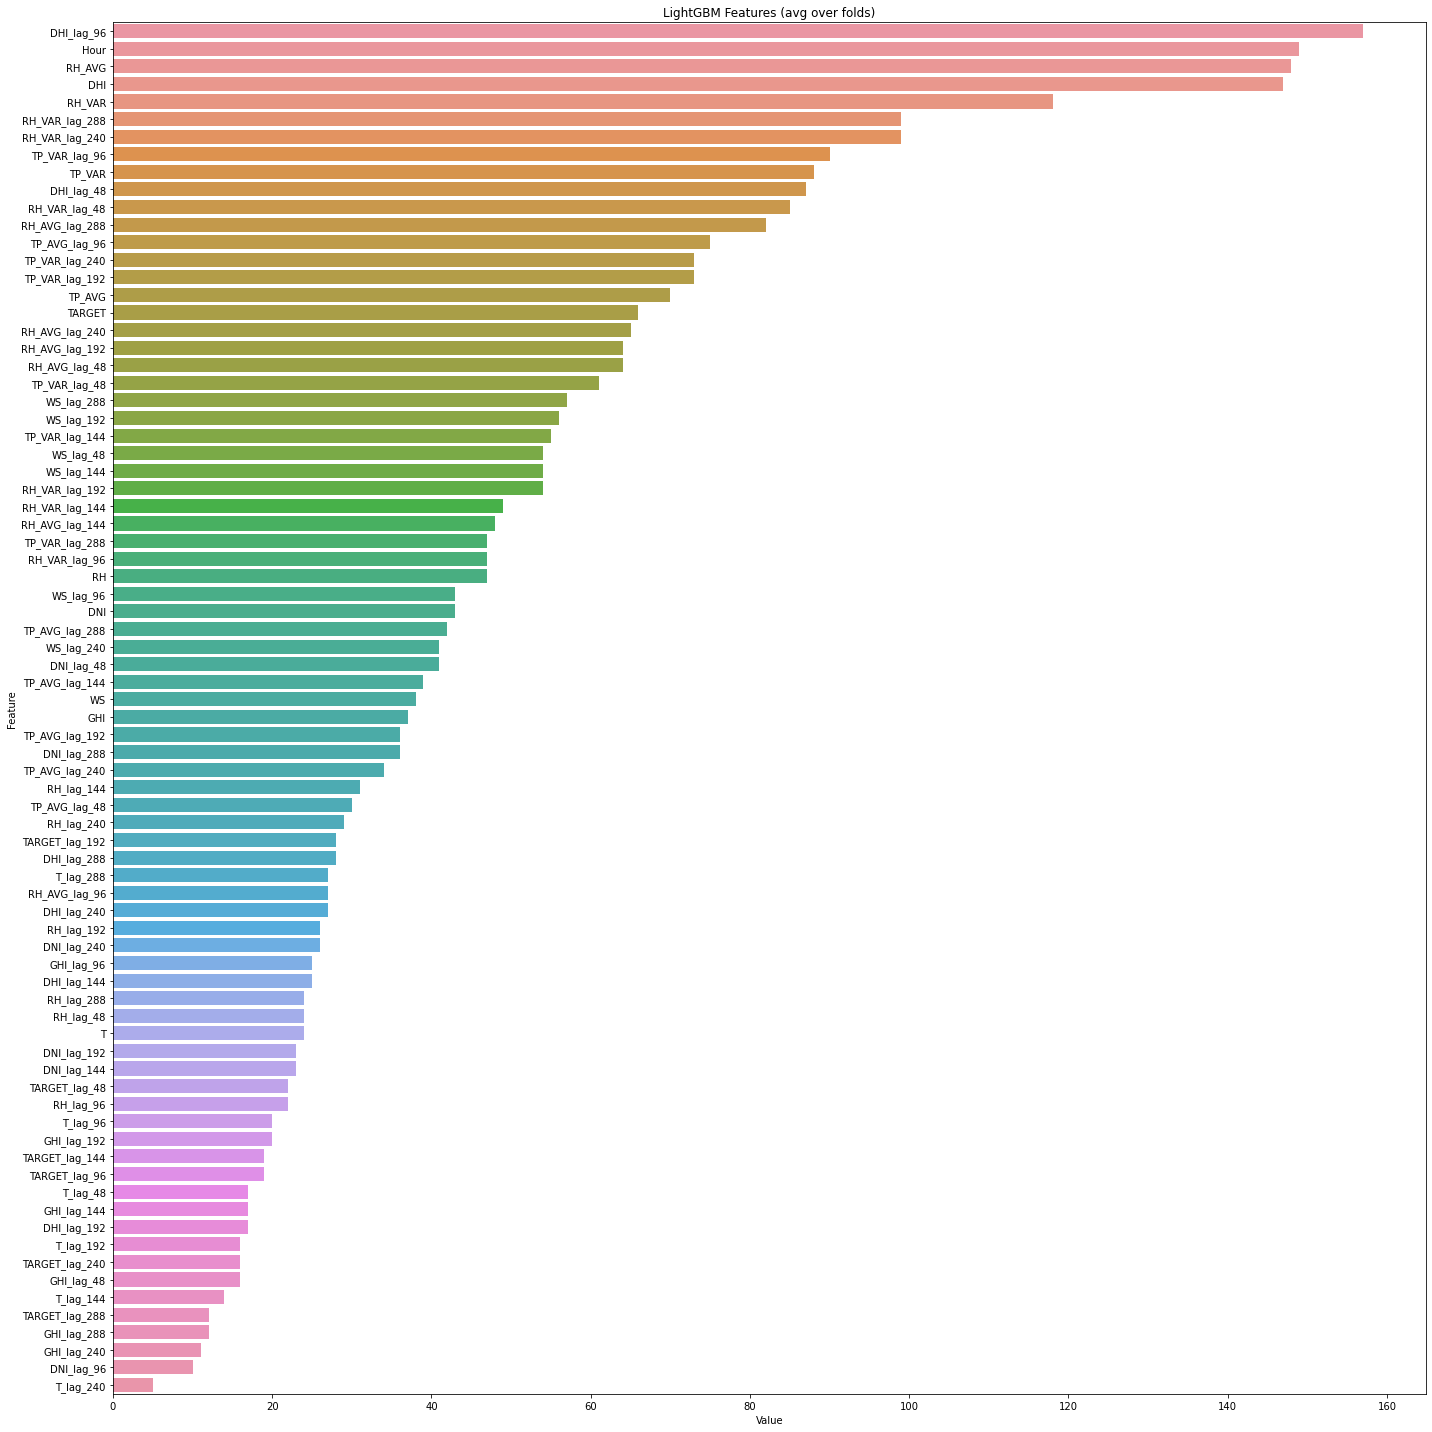

<Figure size 432x288 with 0 Axes>

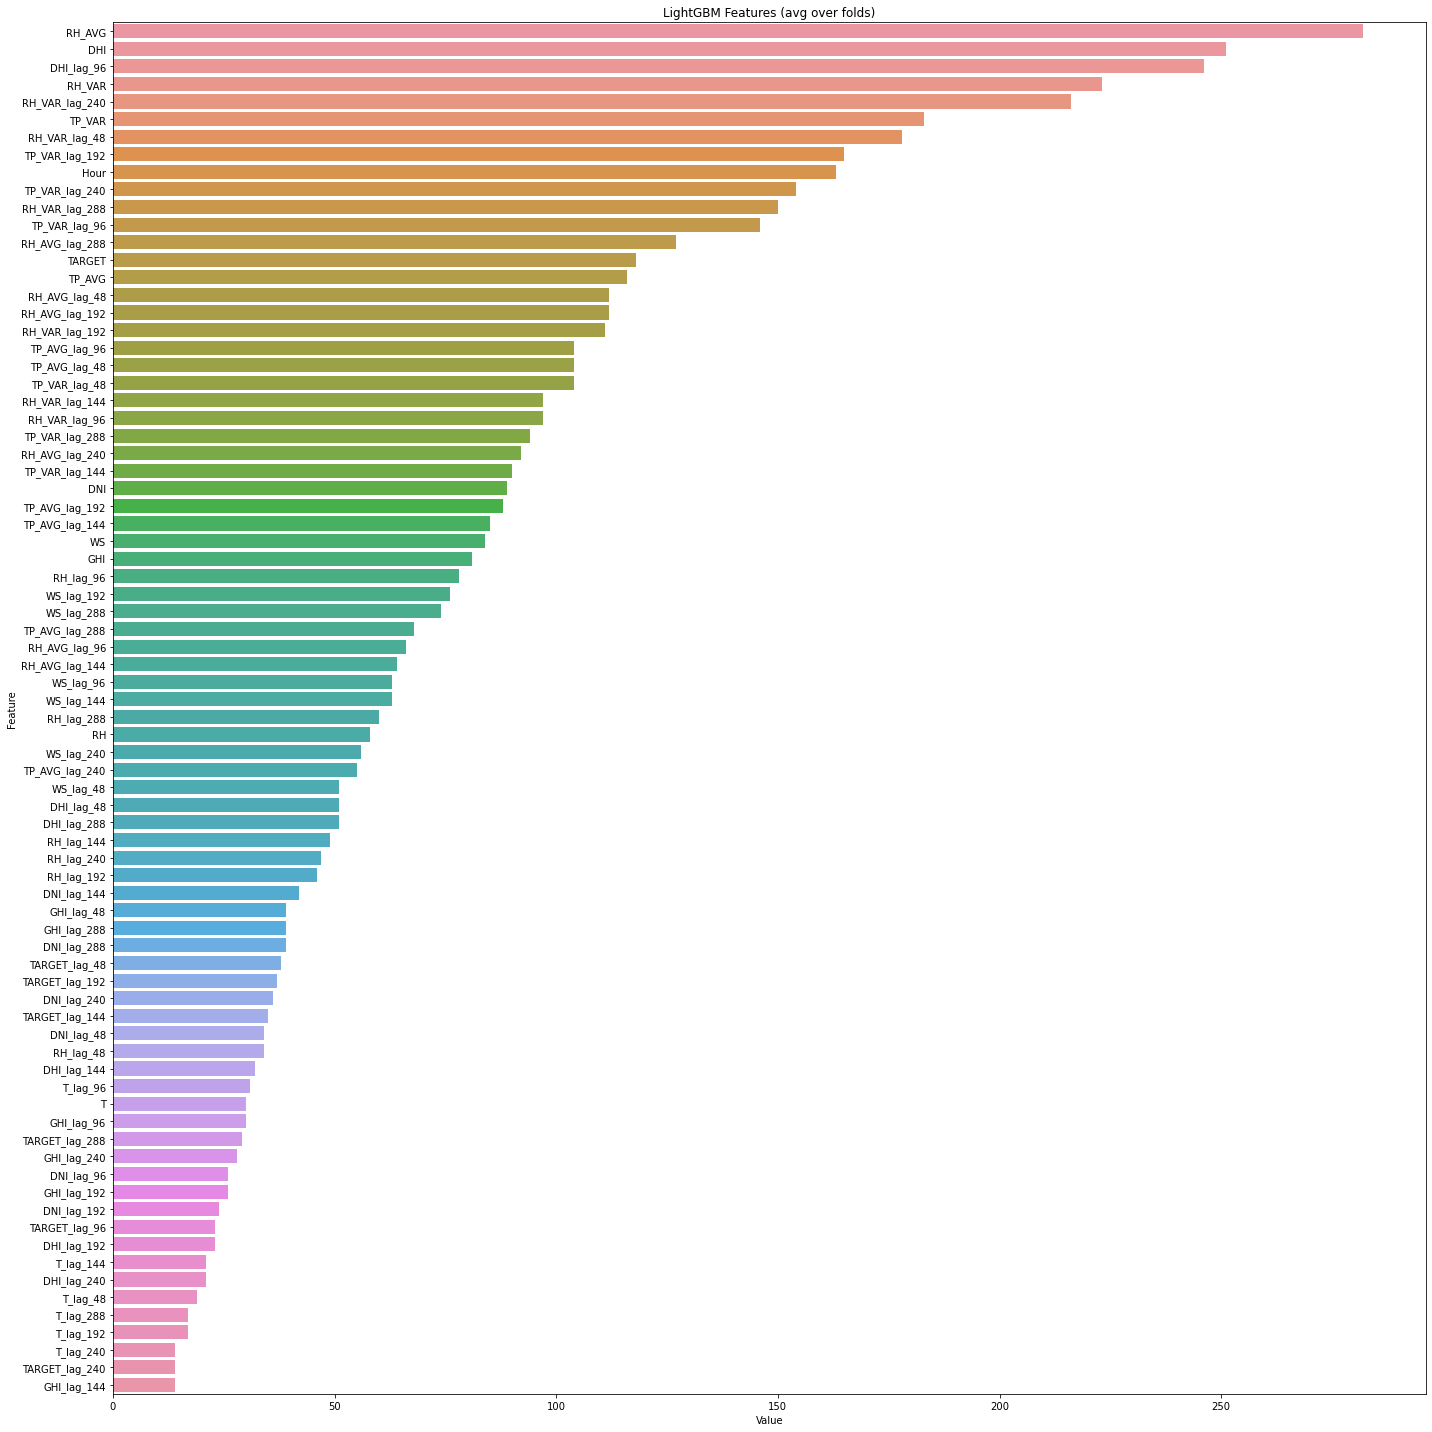

<Figure size 432x288 with 0 Axes>

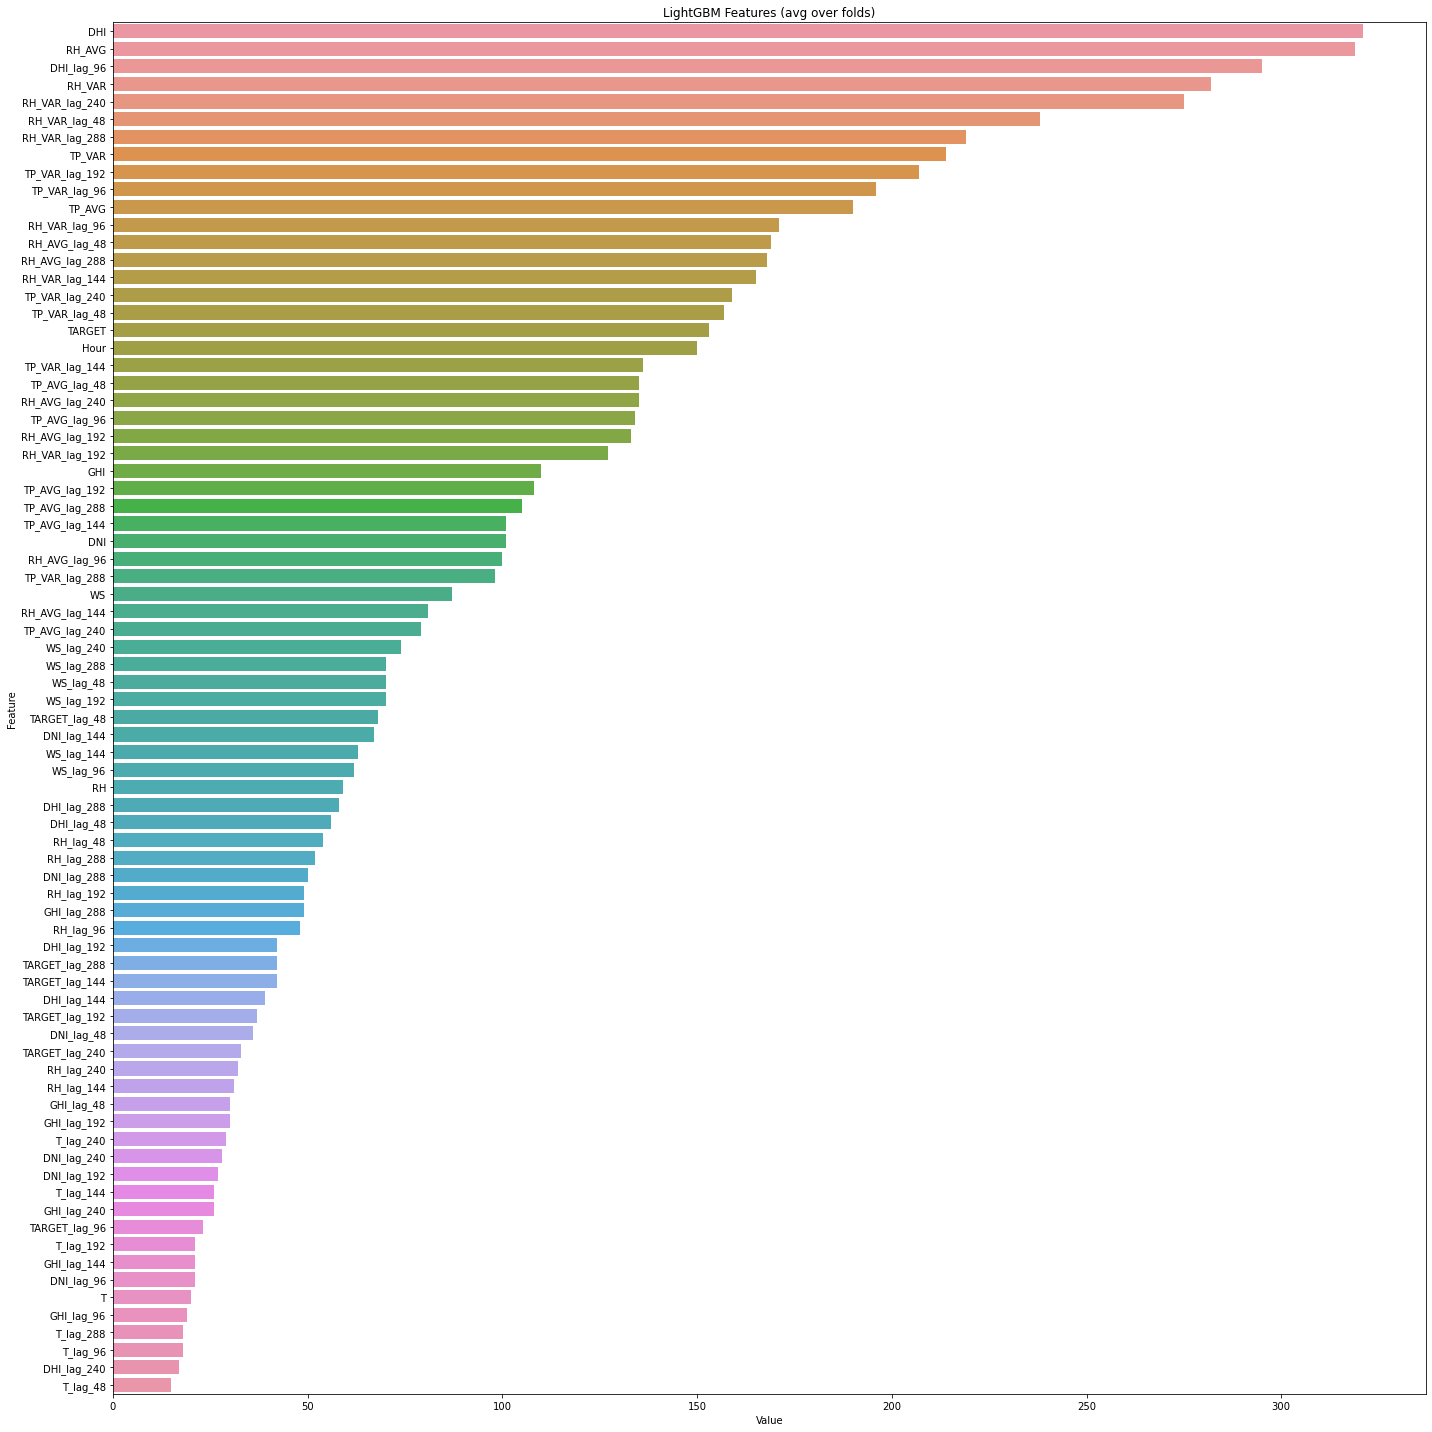

<Figure size 432x288 with 0 Axes>

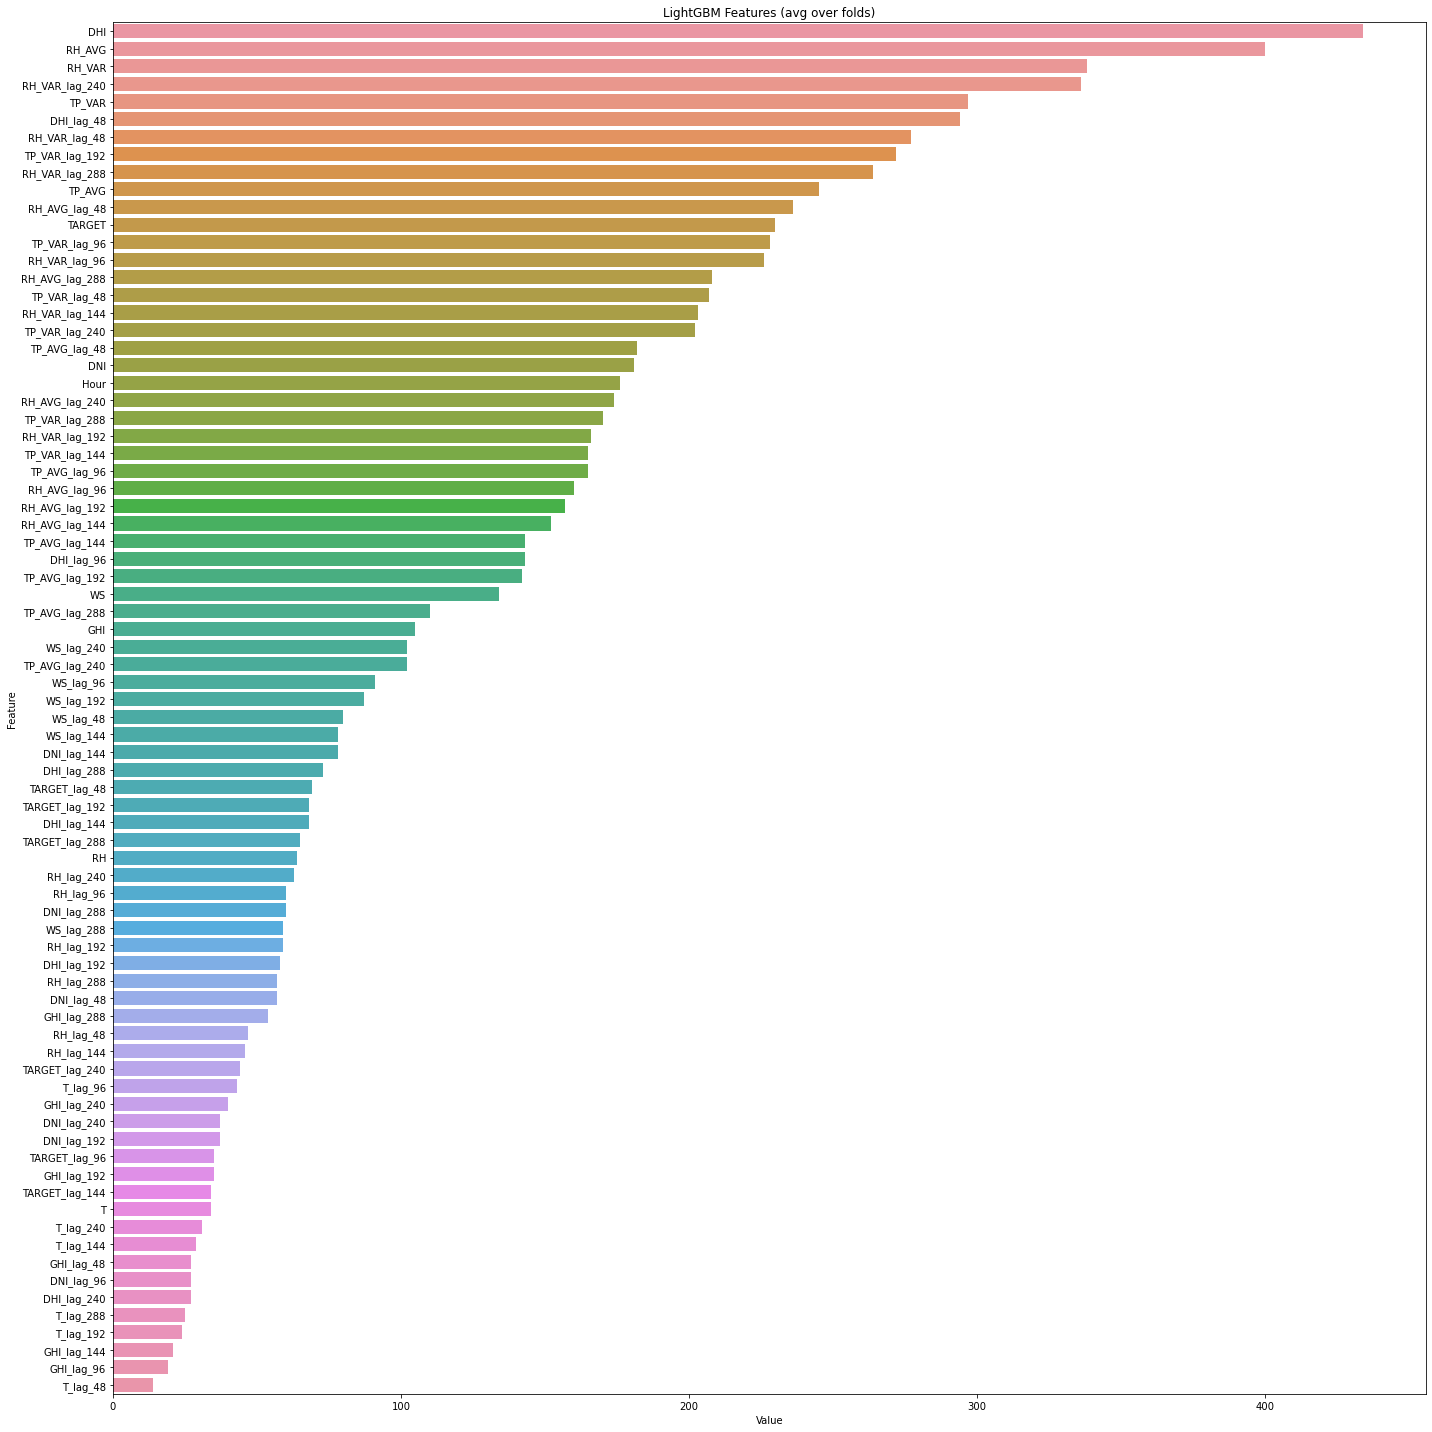

<Figure size 432x288 with 0 Axes>

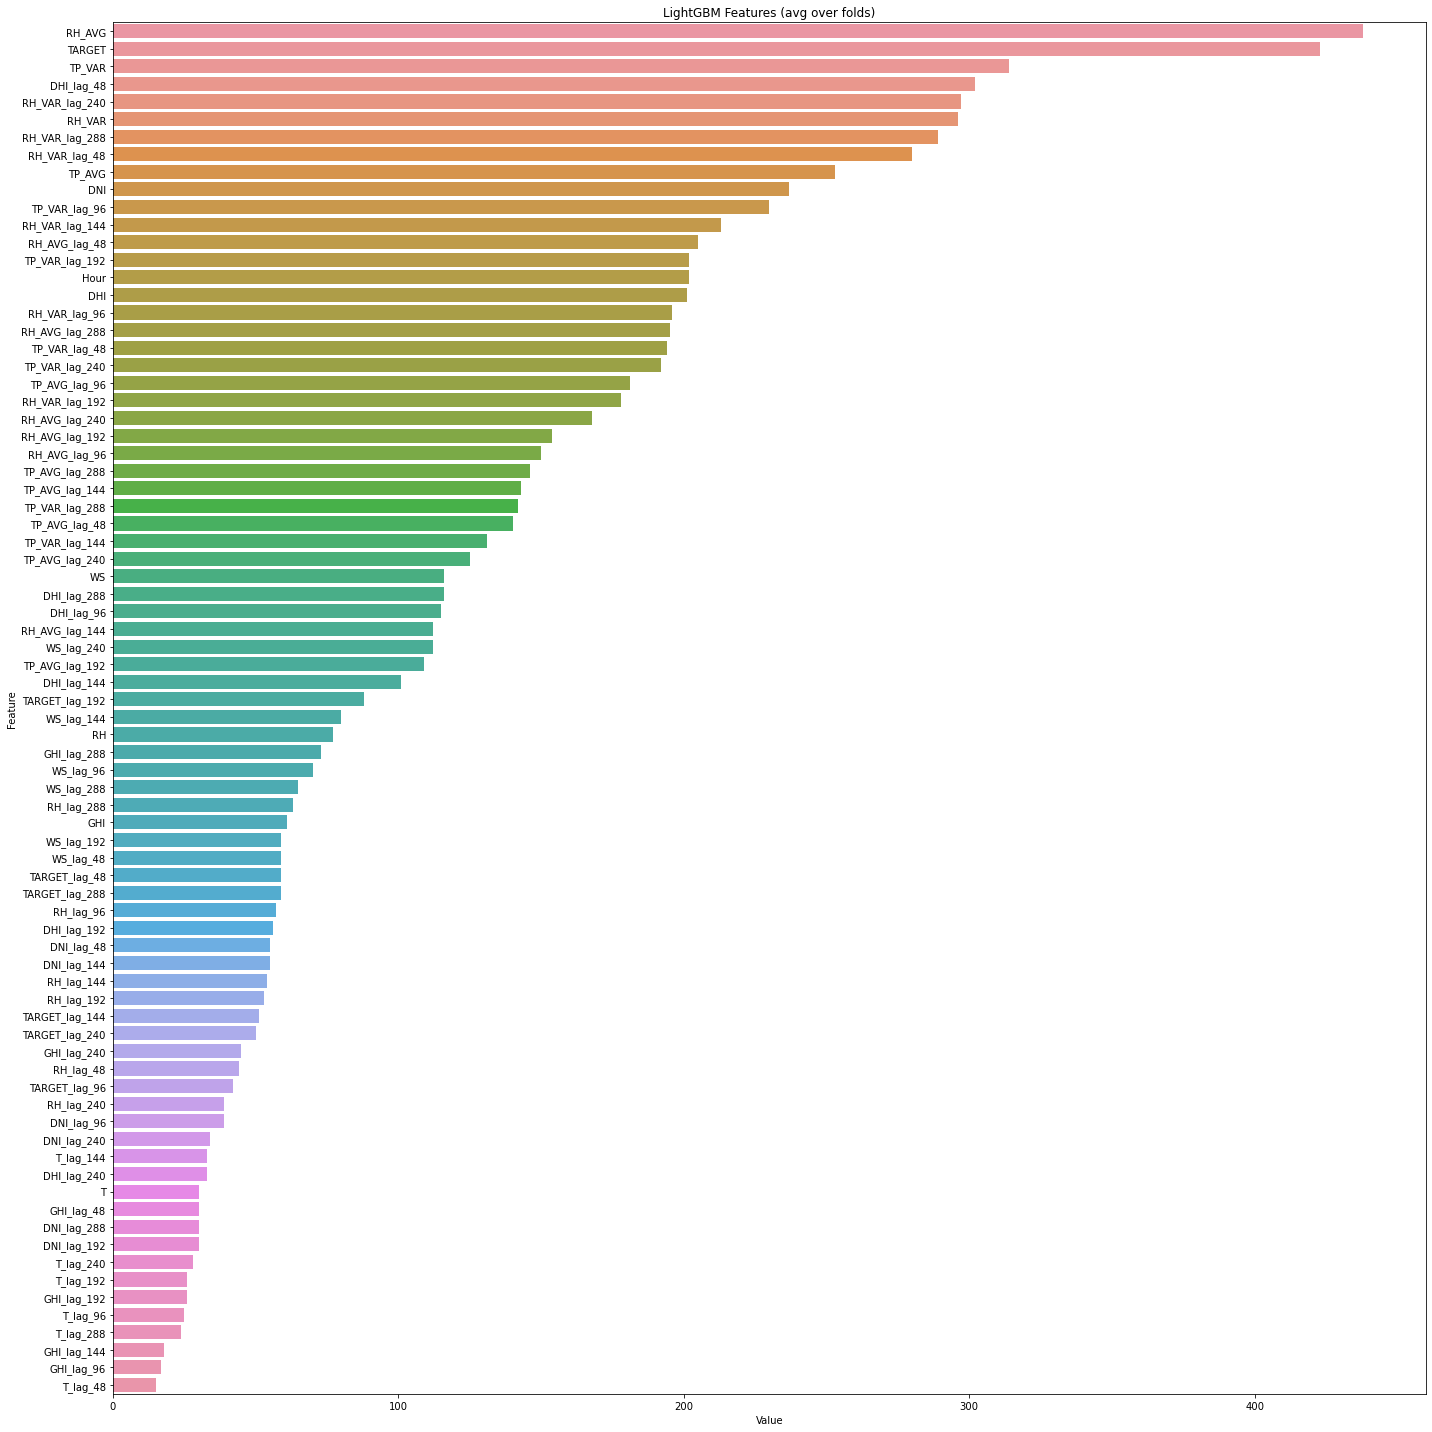

<Figure size 432x288 with 0 Axes>

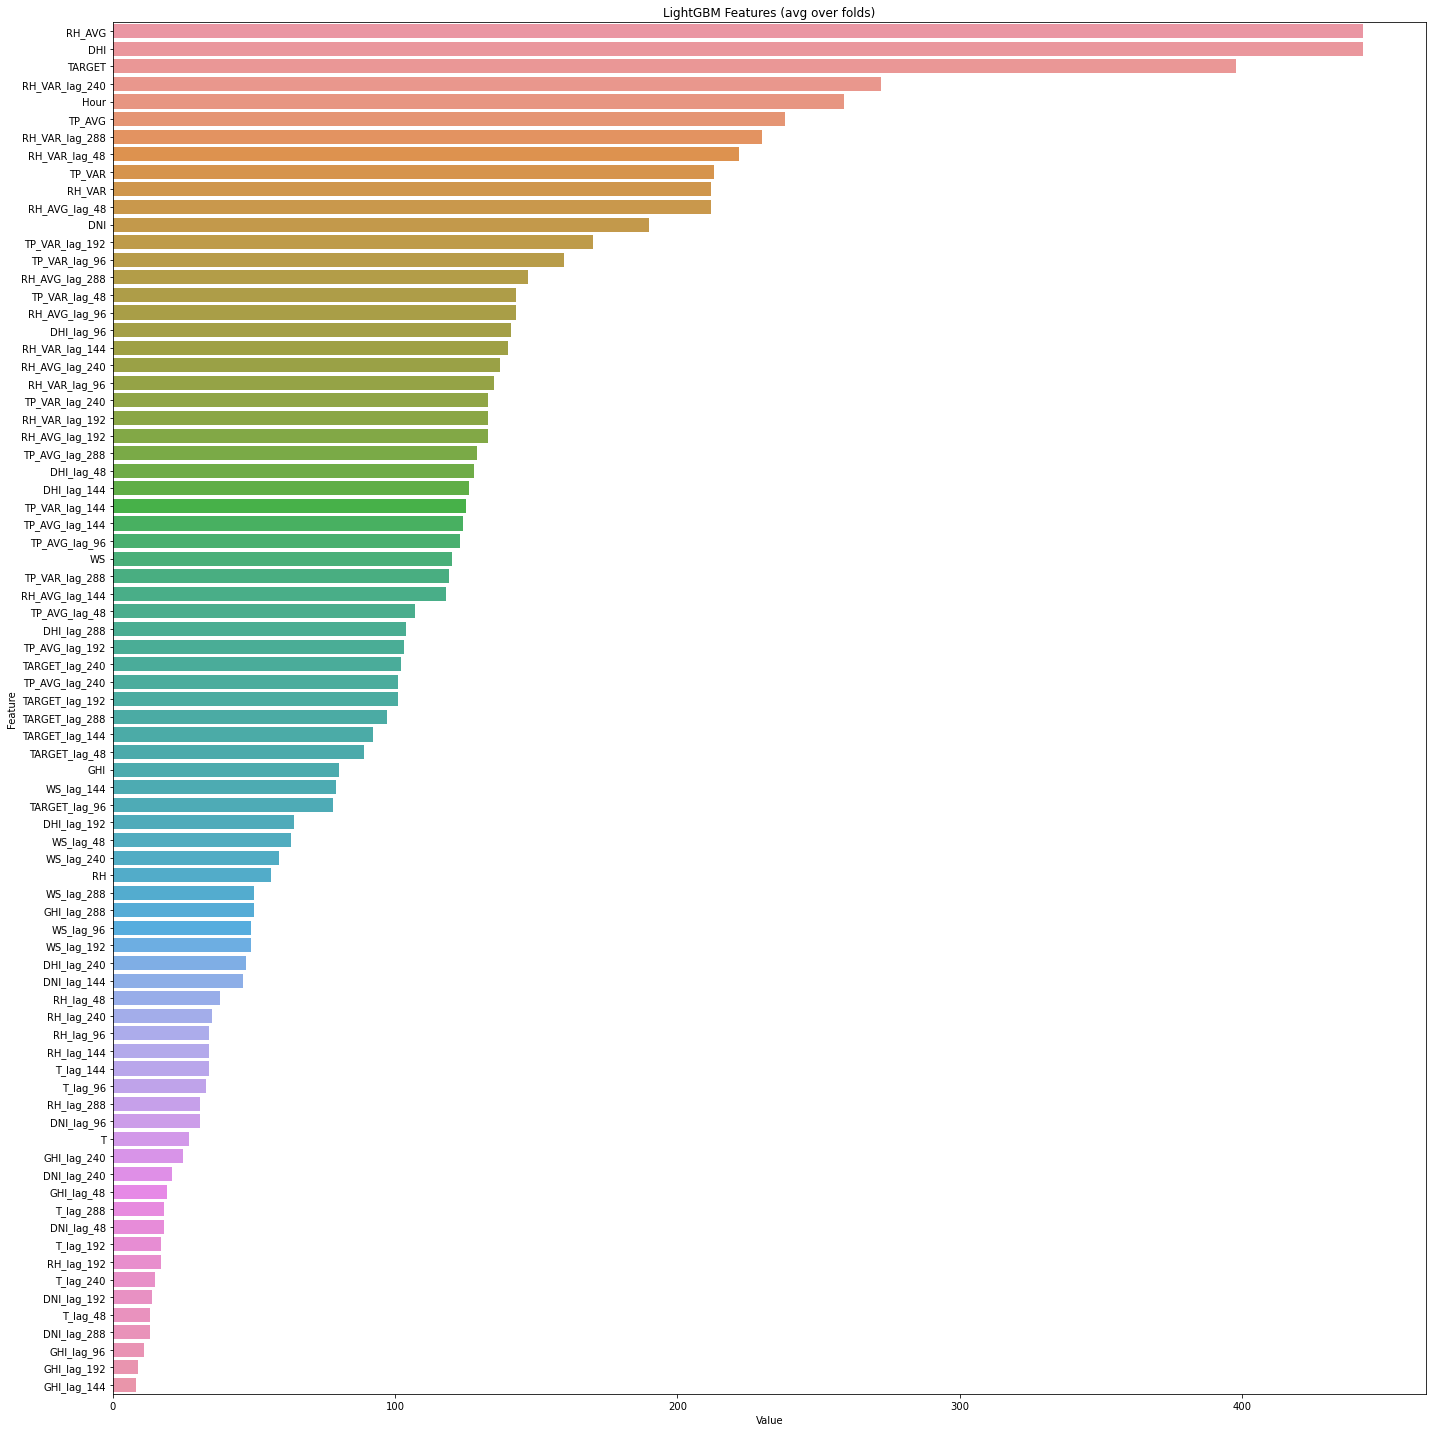

<Figure size 432x288 with 0 Axes>

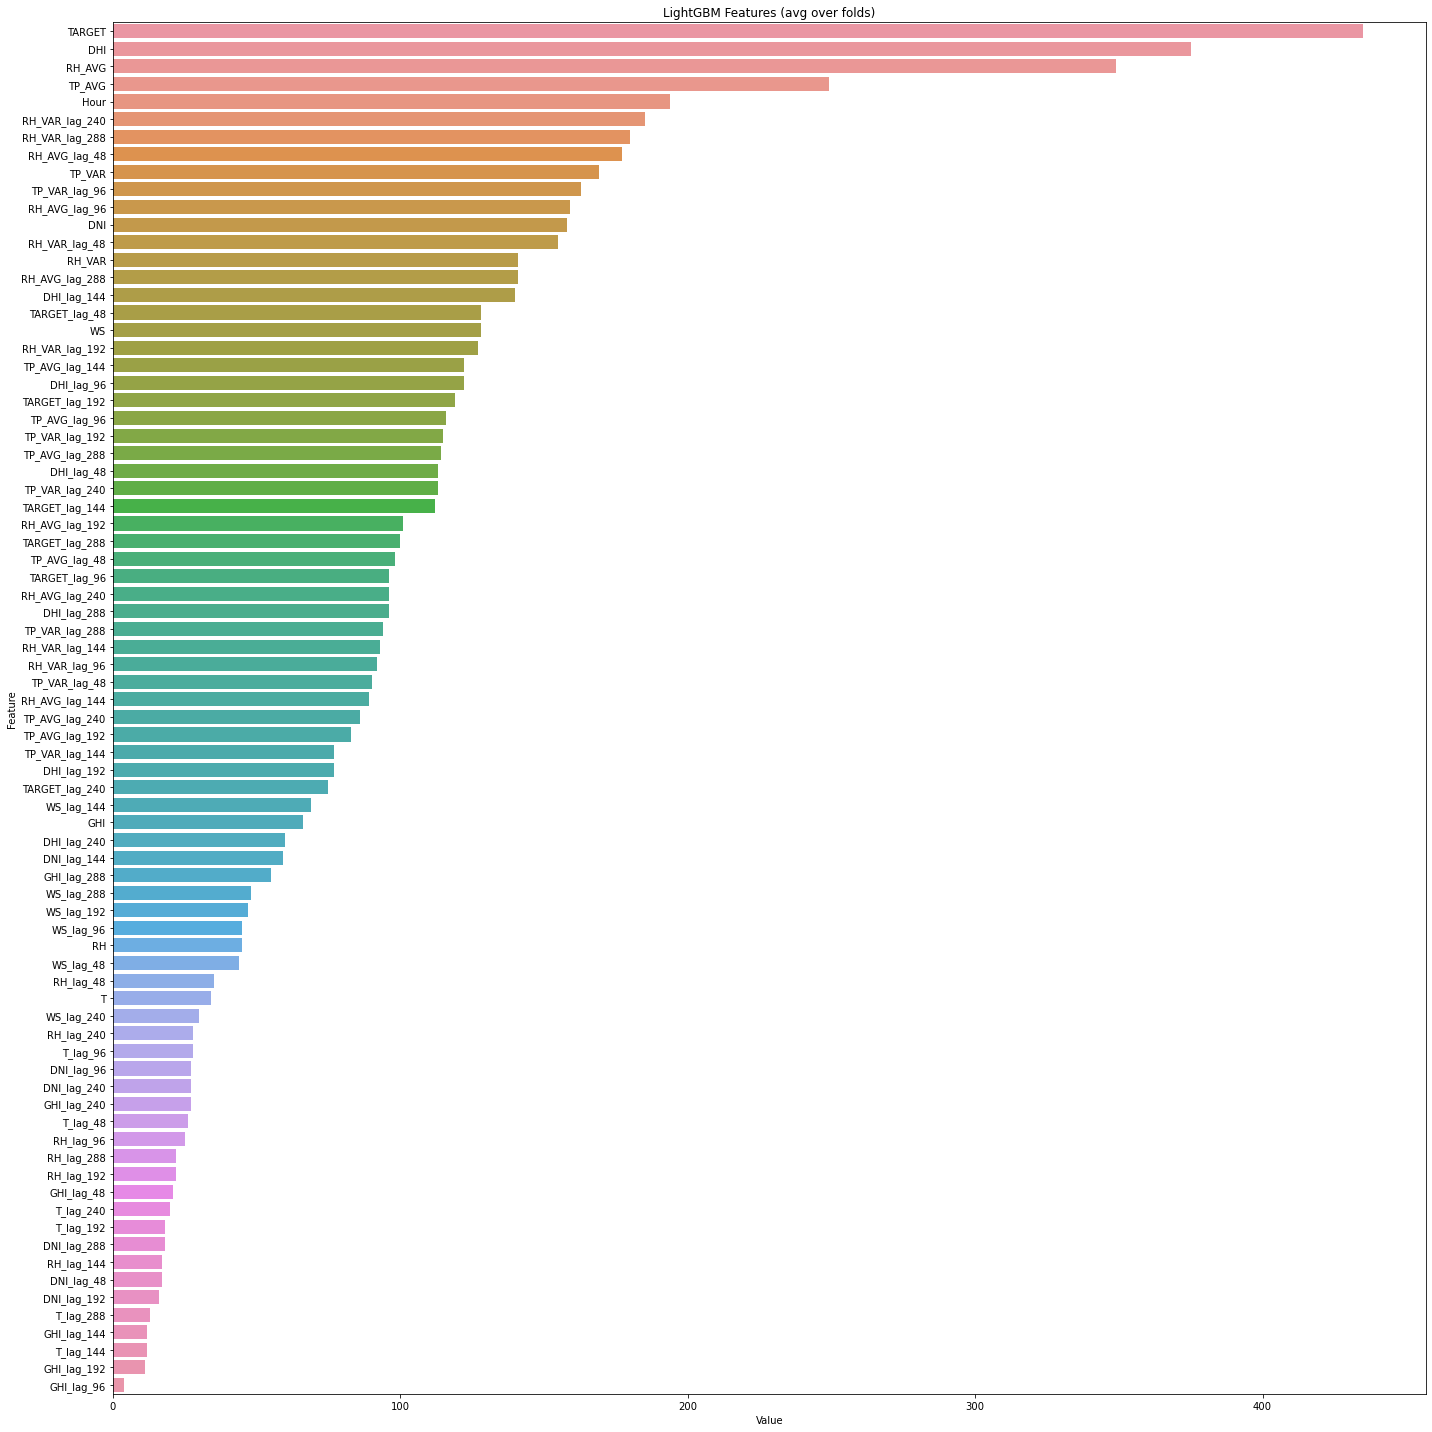

<Figure size 432x288 with 0 Axes>

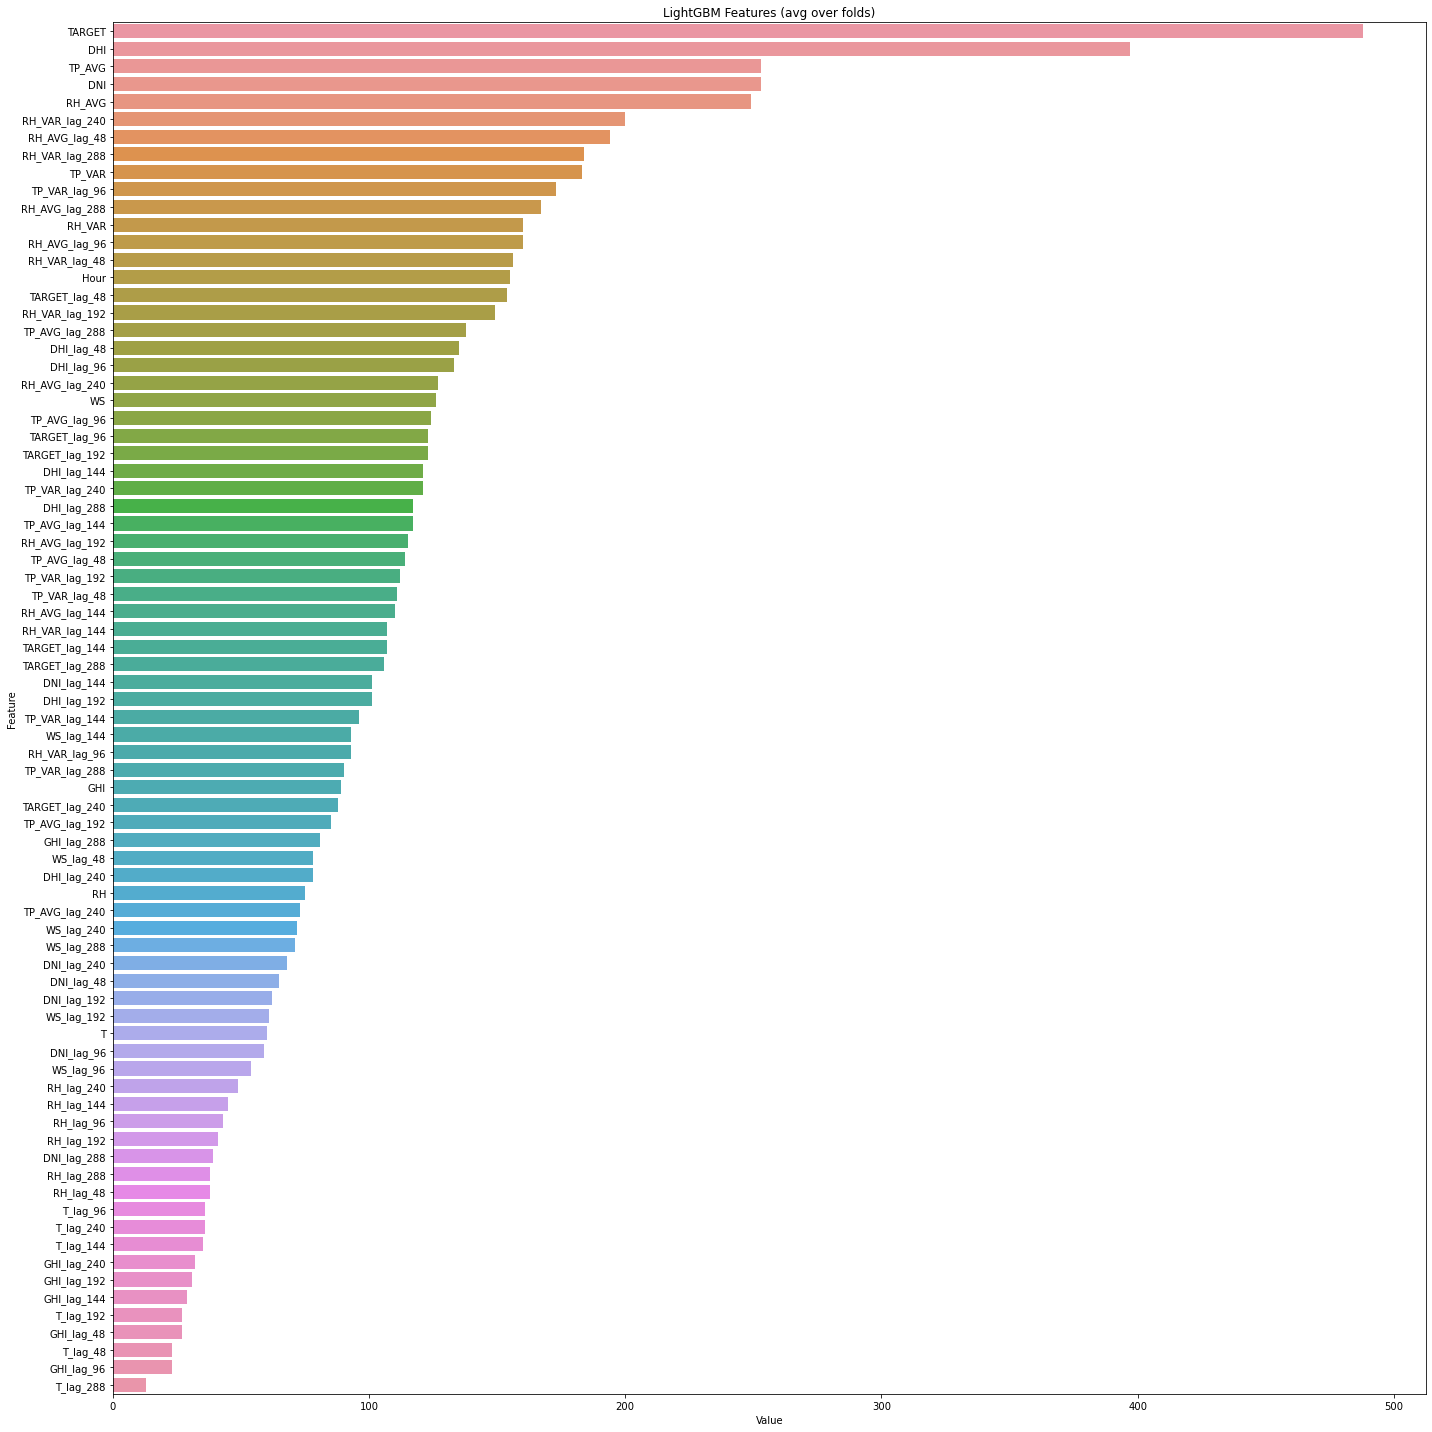

<Figure size 432x288 with 0 Axes>

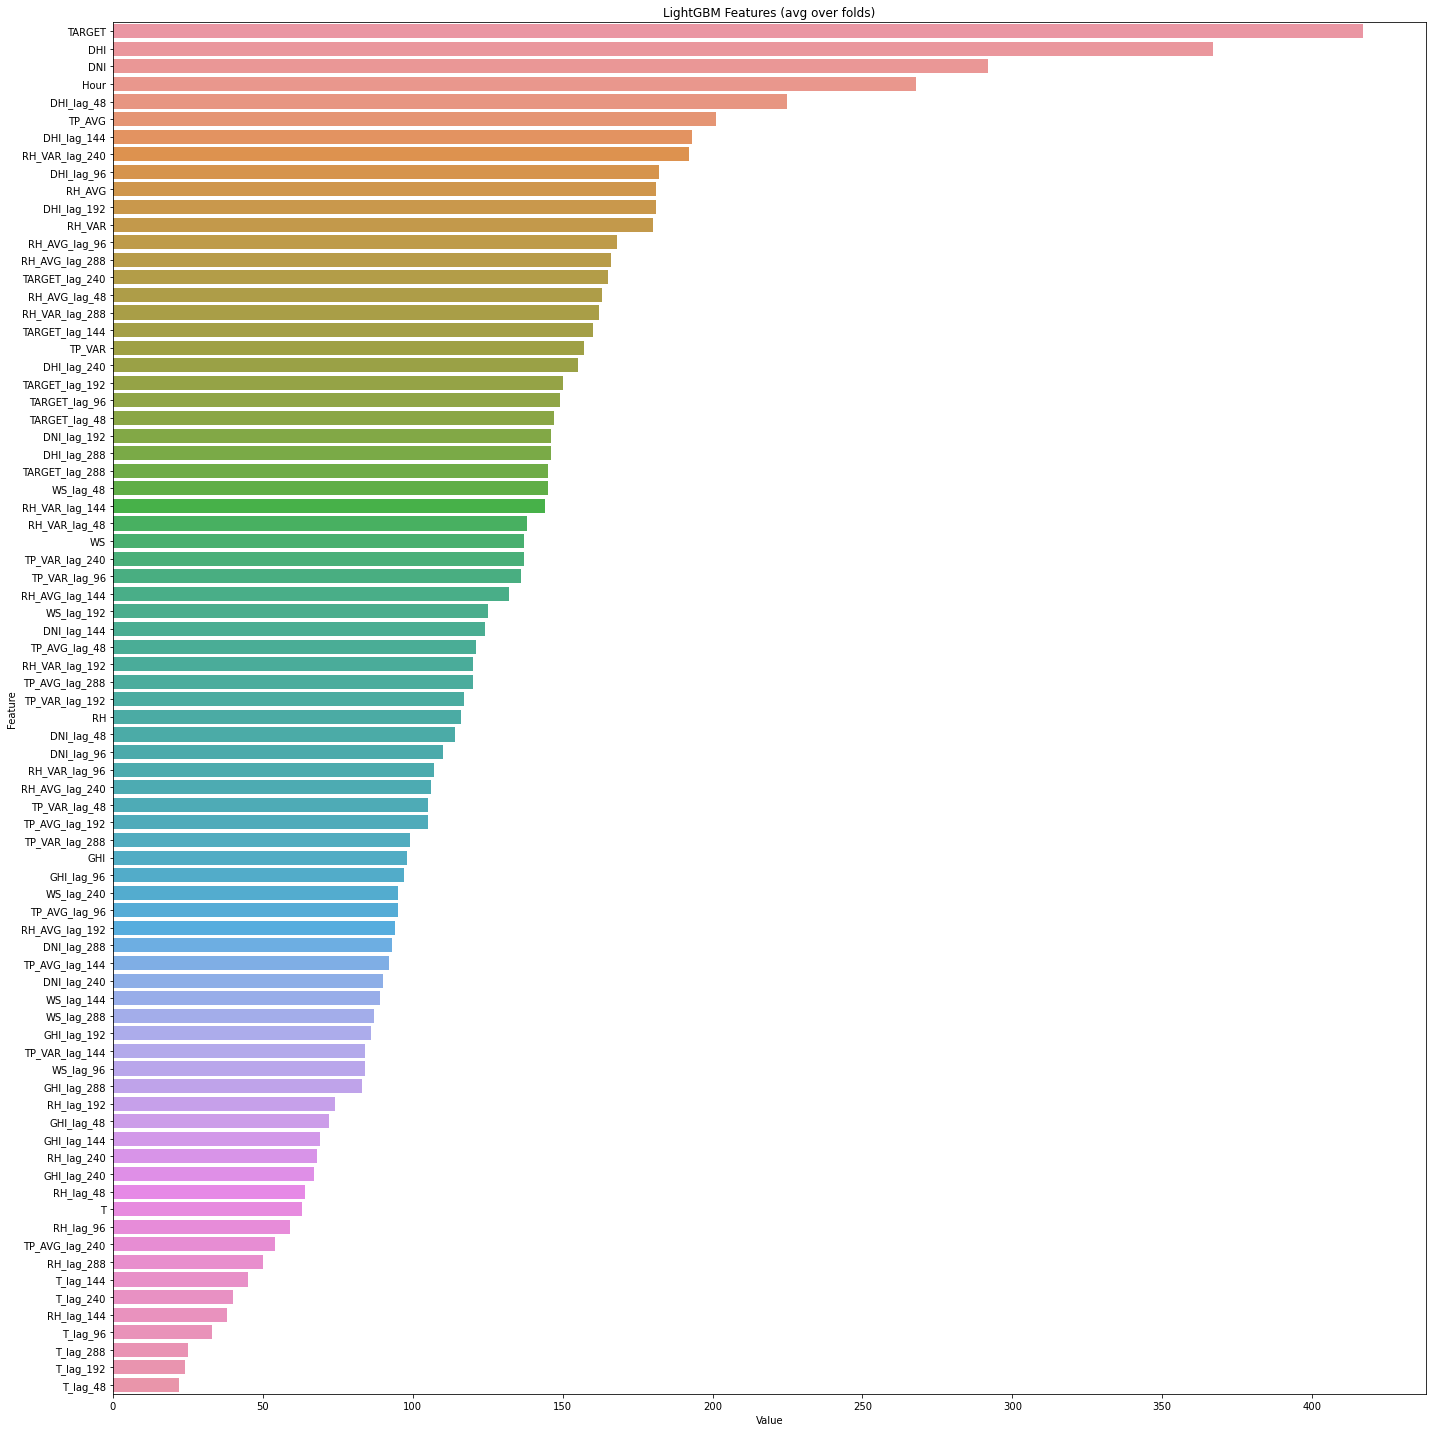

<Figure size 432x288 with 0 Axes>

In [146]:
for i in range(len(models_1)):
    # sorted(zip(clf.feature_importances_, X.columns), reverse=True)
    feature_imp = pd.DataFrame(sorted(zip(models_1[i].feature_importances_,x_train.columns)),
                               columns=['Value','Feature'])

    plt.figure(figsize=(20, 20))
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.show()
    plt.savefig('lgbm_importances-01.png')

In [149]:
# lag model 3 window decross model

submission.loc[submission.id.str.contains("Day7"), "q_0.1":] = results_1.sort_index().values
submission.loc[submission.id.str.contains("Day8"), "q_0.1":] = results_2.sort_index().values
submission[16:33]

#submission.to_csv('./submission/submission_210103-2_re-shiftedModel-GHIAVGVAR.csv', index=False)

,id,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
16,0.csv_Day7_8h00m,2.63,2.78,2.20,2.74,4.57,5.99,4.88,6.28,8.37
17,0.csv_Day7_8h30m,4.62,6.04,7.56,6.46,9.37,11.48,13.56,12.65,17.74
18,0.csv_Day7_9h00m,6.25,7.71,10.53,10.93,15.78,14.65,19.97,21.41,23.19
19,0.csv_Day7_9h30m,7.83,11.87,12.73,14.70,18.94,19.40,23.92,23.80,31.62
20,0.csv_Day7_10h00m,10.31,14.48,15.87,17.71,20.00,19.14,26.13,30.45,34.88
21,0.csv_Day7_10h30m,11.77,16.76,20.53,22.66,24.65,27.43,31.04,37.33,36.48
22,0.csv_Day7_11h00m,12.29,19.77,25.26,28.22,36.26,33.22,36.93,39.22,41.28
23,0.csv_Day7_11h30m,12.60,19.49,23.87,27.28,35.87,33.96,38.39,39.76,41.94
24,0.csv_Day7_12h00m,13.40,21.23,24.18,27.30,36.57,37.14,38.30,43.31,43.77
25,0.csv_Day7_12h30m,14.21,21.26,25.66,29.87,36.20,36.30,42.80,42.30,43.52


지금 변수를 넣고 말고 하는 거를 보면, t 시점의 변수를 너무 넣으면 t시점에 오버피팅 되는 경향이 있다. 결국 shift 변수로 만들어줘야 하는 것 같다.

그리고 확실한 거는 NEW_GHI랑 TA, STC는 쓰잘데기 없는 변수인 것 같다.

MABB 때문에 오버피팅 되지 않았다는 걸 알았으니, MABB도 넣어서 변수 중요도와 로스를 체크해보겠습니다.

In [197]:
train = load_dtypes(TRAIN_PATH)
train.info()

C:\Users\Wyatt\wyatt37\Data\solarpanel\train\train.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52560 entries, 0 to 52559
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Day     52560 non-null  int16  
 1   Hour    52560 non-null  int8   
 2   Minute  52560 non-null  int8   
 3   DHI     52560 non-null  int16  
 4   DNI     52560 non-null  int16  
 5   WS      52560 non-null  float32
 6   RH      52560 non-null  float32
 7   T       52560 non-null  int8   
 8   TARGET  52560 non-null  float32
dtypes: float32(3), int16(3), int8(3)
memory usage: 1.1 MB


In [198]:
def make_MA_BB(train):
    # 이동평균선(Moving Average) 를 6시간 단위로 만들어줍니다.
    train['MA_12'] = train['TARGET'].rolling(window=12).mean()
    train['MA_24'] = train['TARGET'].rolling(window=24).mean()
    train['MA_36'] = train['TARGET'].rolling(window=36).mean()
    train['MA_48'] = train['TARGET'].rolling(window=48).mean()

    # 볼린저밴드(BB) 는 원래 20일 단위이지만, 여기서는 12시간 단위로 만들어주겠습니다.
    train['BB_UPPER'] = train['MA_24'] + 2*(train['TARGET'].rolling(24).std())
    train['BB_DOWN'] = train['MA_24'] - 2*(train['TARGET'].rolling(24).std())
    
    return train

In [199]:
train = make_features(train)

original_shape:  (52560, 9)
feature_creationed:  (52560, 12)


In [200]:
train = make_MA_BB(train)
train.shape

(52560, 18)

In [201]:
train.columns

Index(['Hour', 'DHI', 'DNI', 'WS', 'RH', 'T', 'TARGET', 'GHI', 'RH_AVG',
       'TP_AVG', 'RH_VAR', 'TP_VAR', 'MA_12', 'MA_24', 'MA_36', 'MA_48',
       'BB_UPPER', 'BB_DOWN'],
      dtype='object')

In [202]:
shifted_columns = ['DHI', 'DNI', 'WS', 'RH', 'T', 'TARGET', 'GHI', 'RH_AVG',
       'TP_AVG', 'RH_VAR', 'TP_VAR']
lags = [48, 96, 144, 192, 240, 288]

train = shift_columns(train, shifted_columns, lags)
train.shape

(52560, 84)

In [203]:
train.columns

Index(['Hour', 'DHI', 'DNI', 'WS', 'RH', 'T', 'TARGET', 'GHI', 'RH_AVG',
       'TP_AVG', 'RH_VAR', 'TP_VAR', 'MA_12', 'MA_24', 'MA_36', 'MA_48',
       'BB_UPPER', 'BB_DOWN', 'DHI_lag_48', 'DNI_lag_48', 'WS_lag_48',
       'RH_lag_48', 'T_lag_48', 'TARGET_lag_48', 'GHI_lag_48', 'RH_AVG_lag_48',
       'TP_AVG_lag_48', 'RH_VAR_lag_48', 'TP_VAR_lag_48', 'DHI_lag_96',
       'DNI_lag_96', 'WS_lag_96', 'RH_lag_96', 'T_lag_96', 'TARGET_lag_96',
       'GHI_lag_96', 'RH_AVG_lag_96', 'TP_AVG_lag_96', 'RH_VAR_lag_96',
       'TP_VAR_lag_96', 'DHI_lag_144', 'DNI_lag_144', 'WS_lag_144',
       'RH_lag_144', 'T_lag_144', 'TARGET_lag_144', 'GHI_lag_144',
       'RH_AVG_lag_144', 'TP_AVG_lag_144', 'RH_VAR_lag_144', 'TP_VAR_lag_144',
       'DHI_lag_192', 'DNI_lag_192', 'WS_lag_192', 'RH_lag_192', 'T_lag_192',
       'TARGET_lag_192', 'GHI_lag_192', 'RH_AVG_lag_192', 'TP_AVG_lag_192',
       'RH_VAR_lag_192', 'TP_VAR_lag_192', 'DHI_lag_240', 'DNI_lag_240',
       'WS_lag_240', 'RH_lag_240', 'T_lag_

In [204]:
# 타겟값을 미리 만들어줘야 합니다.
train['TARGET_1'] = train.TARGET.shift(-48)
train['TARGET_2'] = train.TARGET_1.shift(-48)

train.dropna(inplace=True)
train.shape

(52176, 86)

In [205]:
X = train[:38400]
val = train[38400:]

x_train, y_train_1, y_train_2, x_val, y_val_1, y_val_2 = make_train_test_val(X, val, X.columns[:-2])

(38400, 84)


In [206]:
class HiddenPrints: # print를 막아주는 클래스 입니다.
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout
        
with HiddenPrints():
    df_test = []

    for i in range(81):
        file_path = TEST_PATH + '/' + str(i) + '.csv'
        temp = pd.read_csv(file_path)
        temp = make_features(temp)
        temp = make_MA_BB(temp)
        temp = shift_columns(temp, shifted_columns, lags).dropna()
        df_test.append(temp)

    X_test = pd.concat(df_test)
print(X_test.shape)

(3888, 84)


In [207]:
# Target1
models_1, results_1 = train_data(x_train, y_train_1, x_val, y_val_1, X_test)

# Target2
models_2, results_2 = train_data(x_train, y_train_2, x_val, y_val_2, X_test)

0.1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[117]	valid_0's quantile: 1.57016
0.2
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[175]	valid_0's quantile: 2.5116
0.3
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
Training until validation scores don't improve for 300 rounds
[500]	valid_0's quantile: 2.97297
Early stopping, best iteration is:
[302]	valid_0's quantile: 2.96141
0.4
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
Training until validation scores don't improve for 300 rounds
[500]	valid_0's quantile: 3.

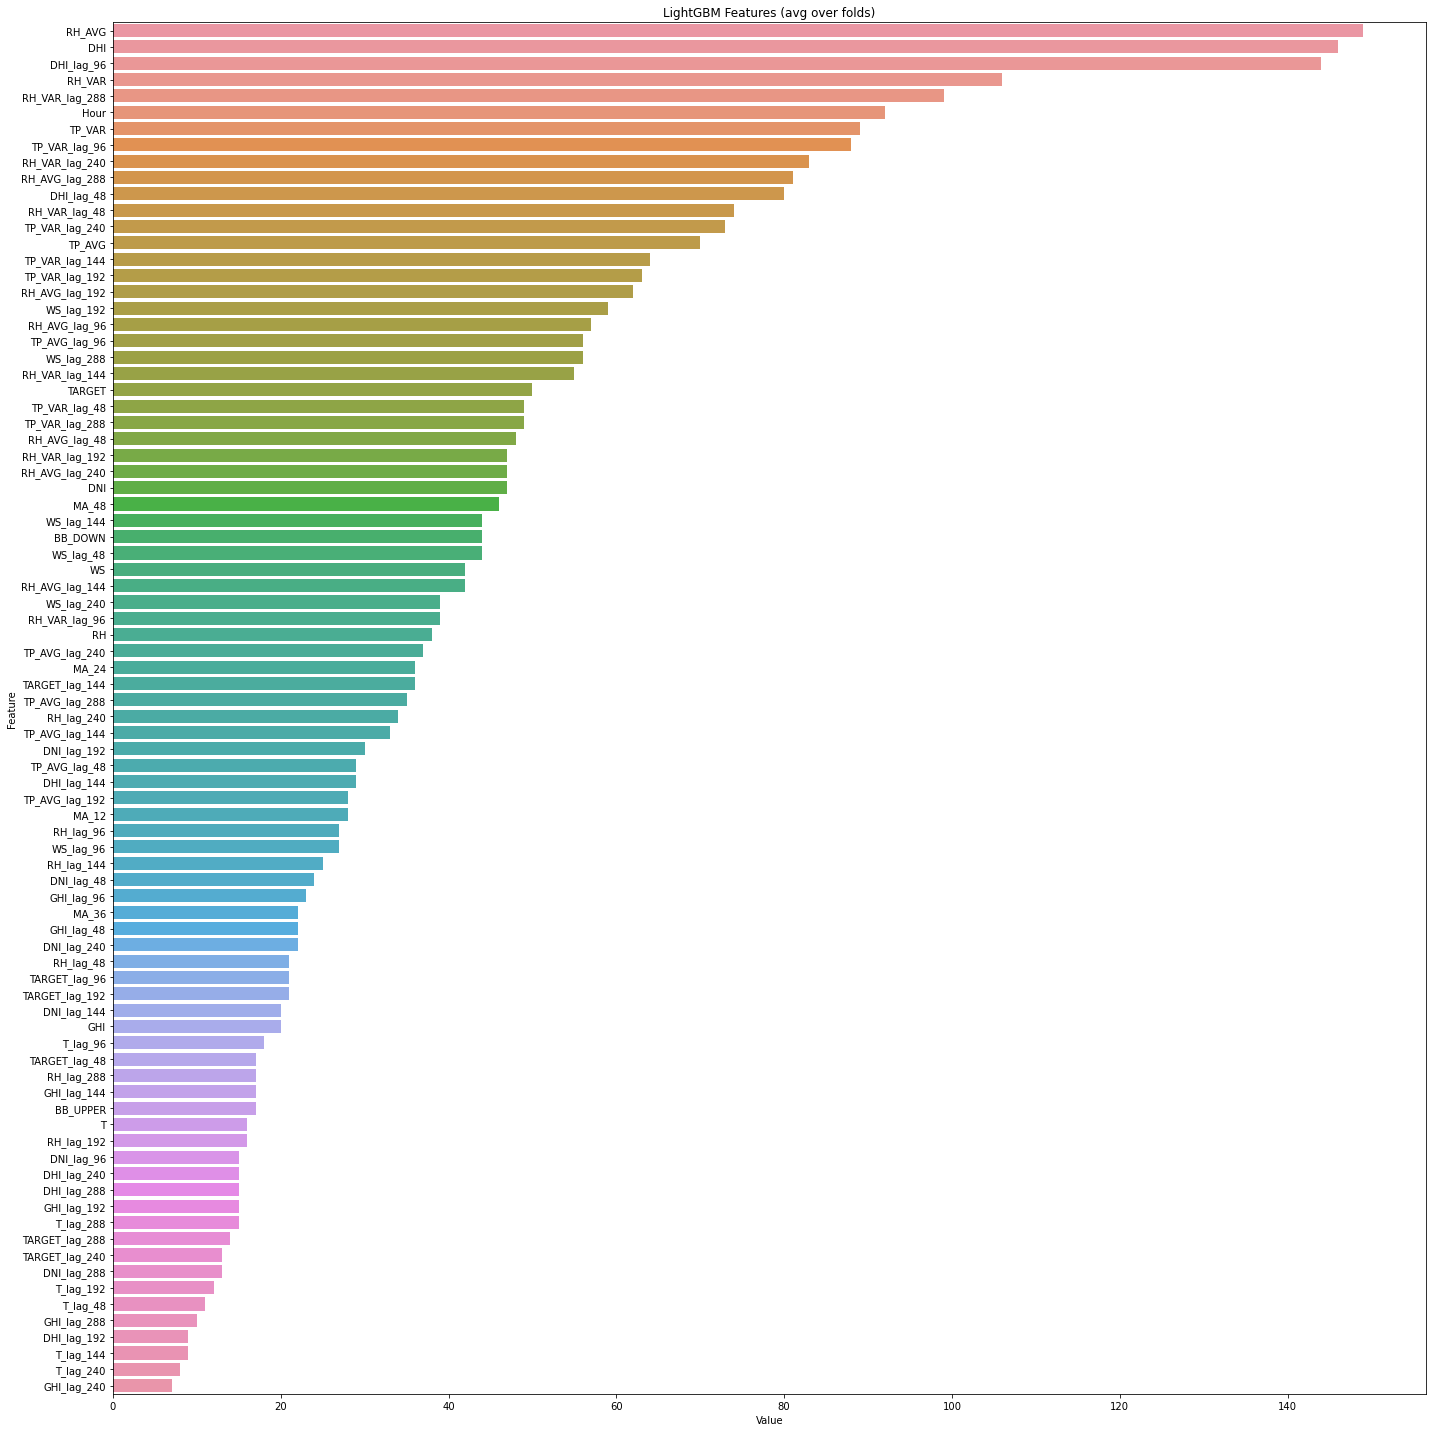

<Figure size 432x288 with 0 Axes>

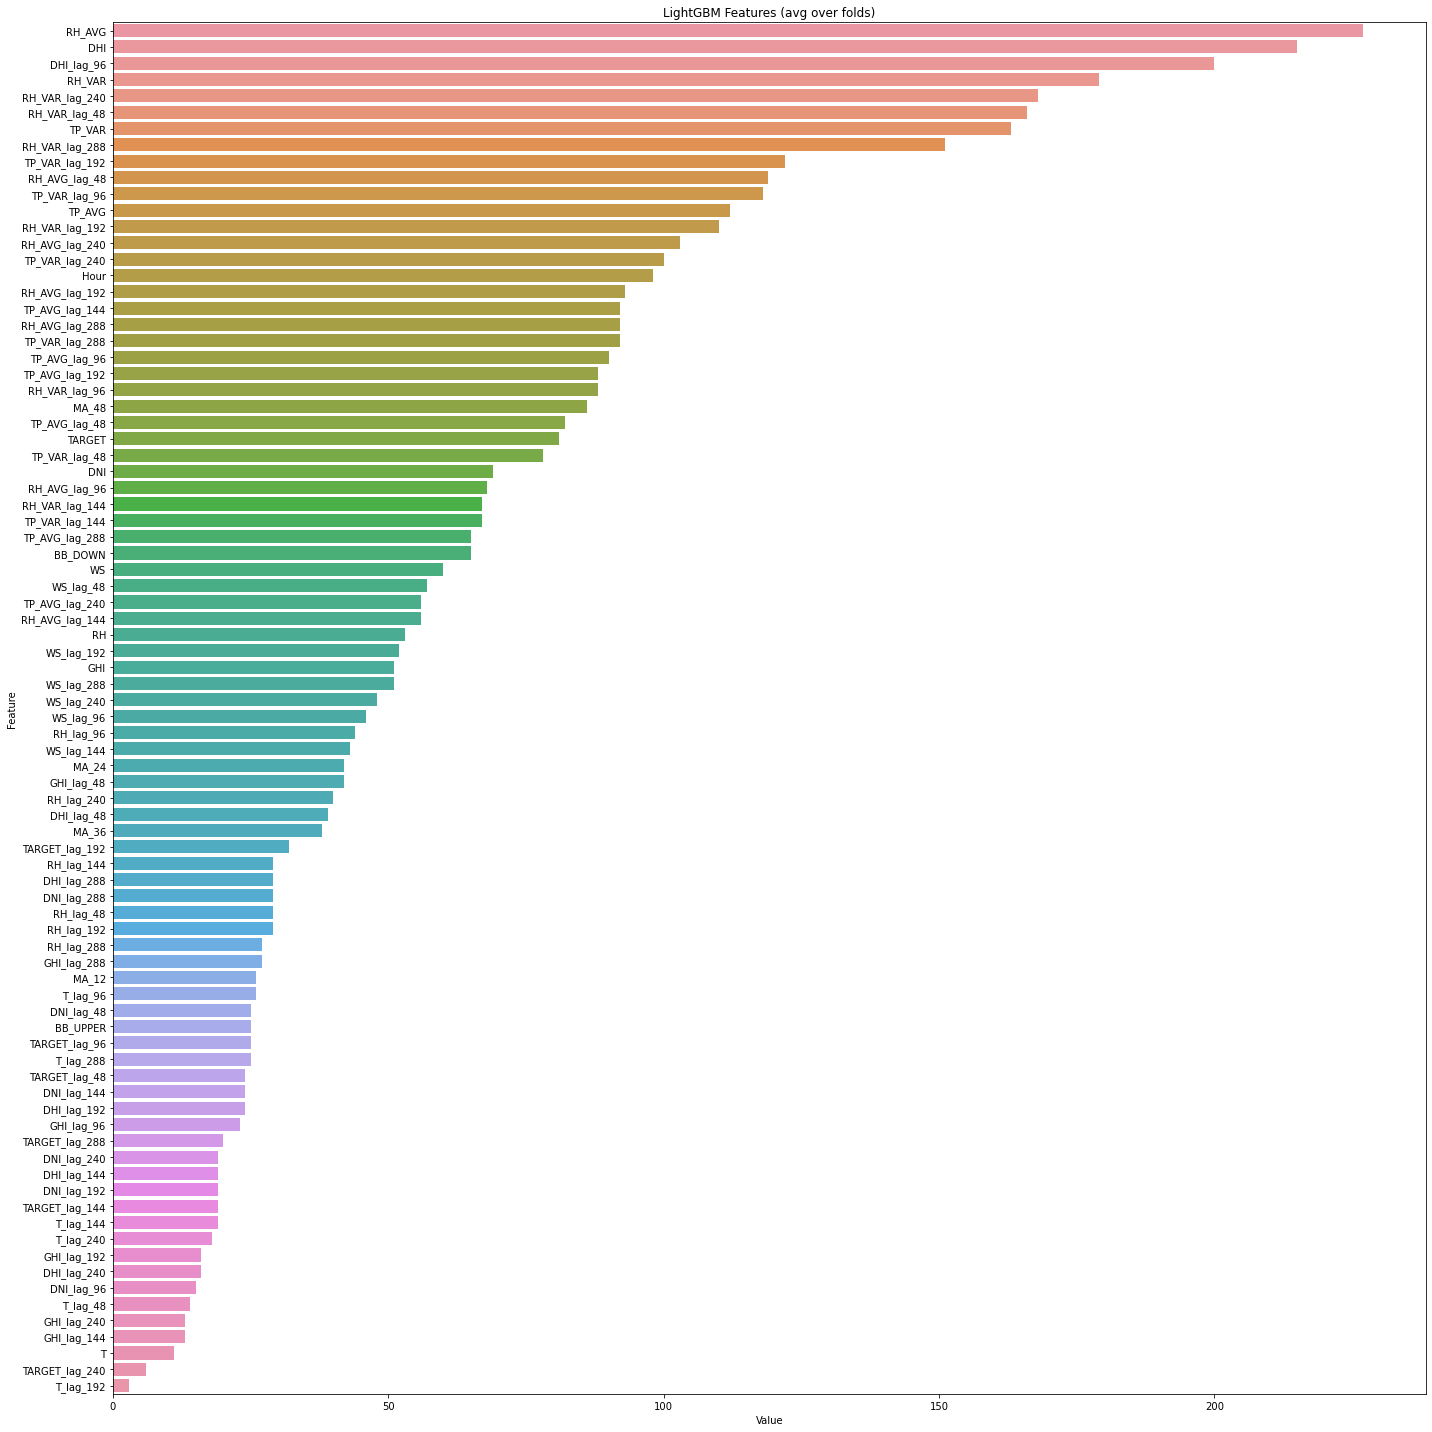

<Figure size 432x288 with 0 Axes>

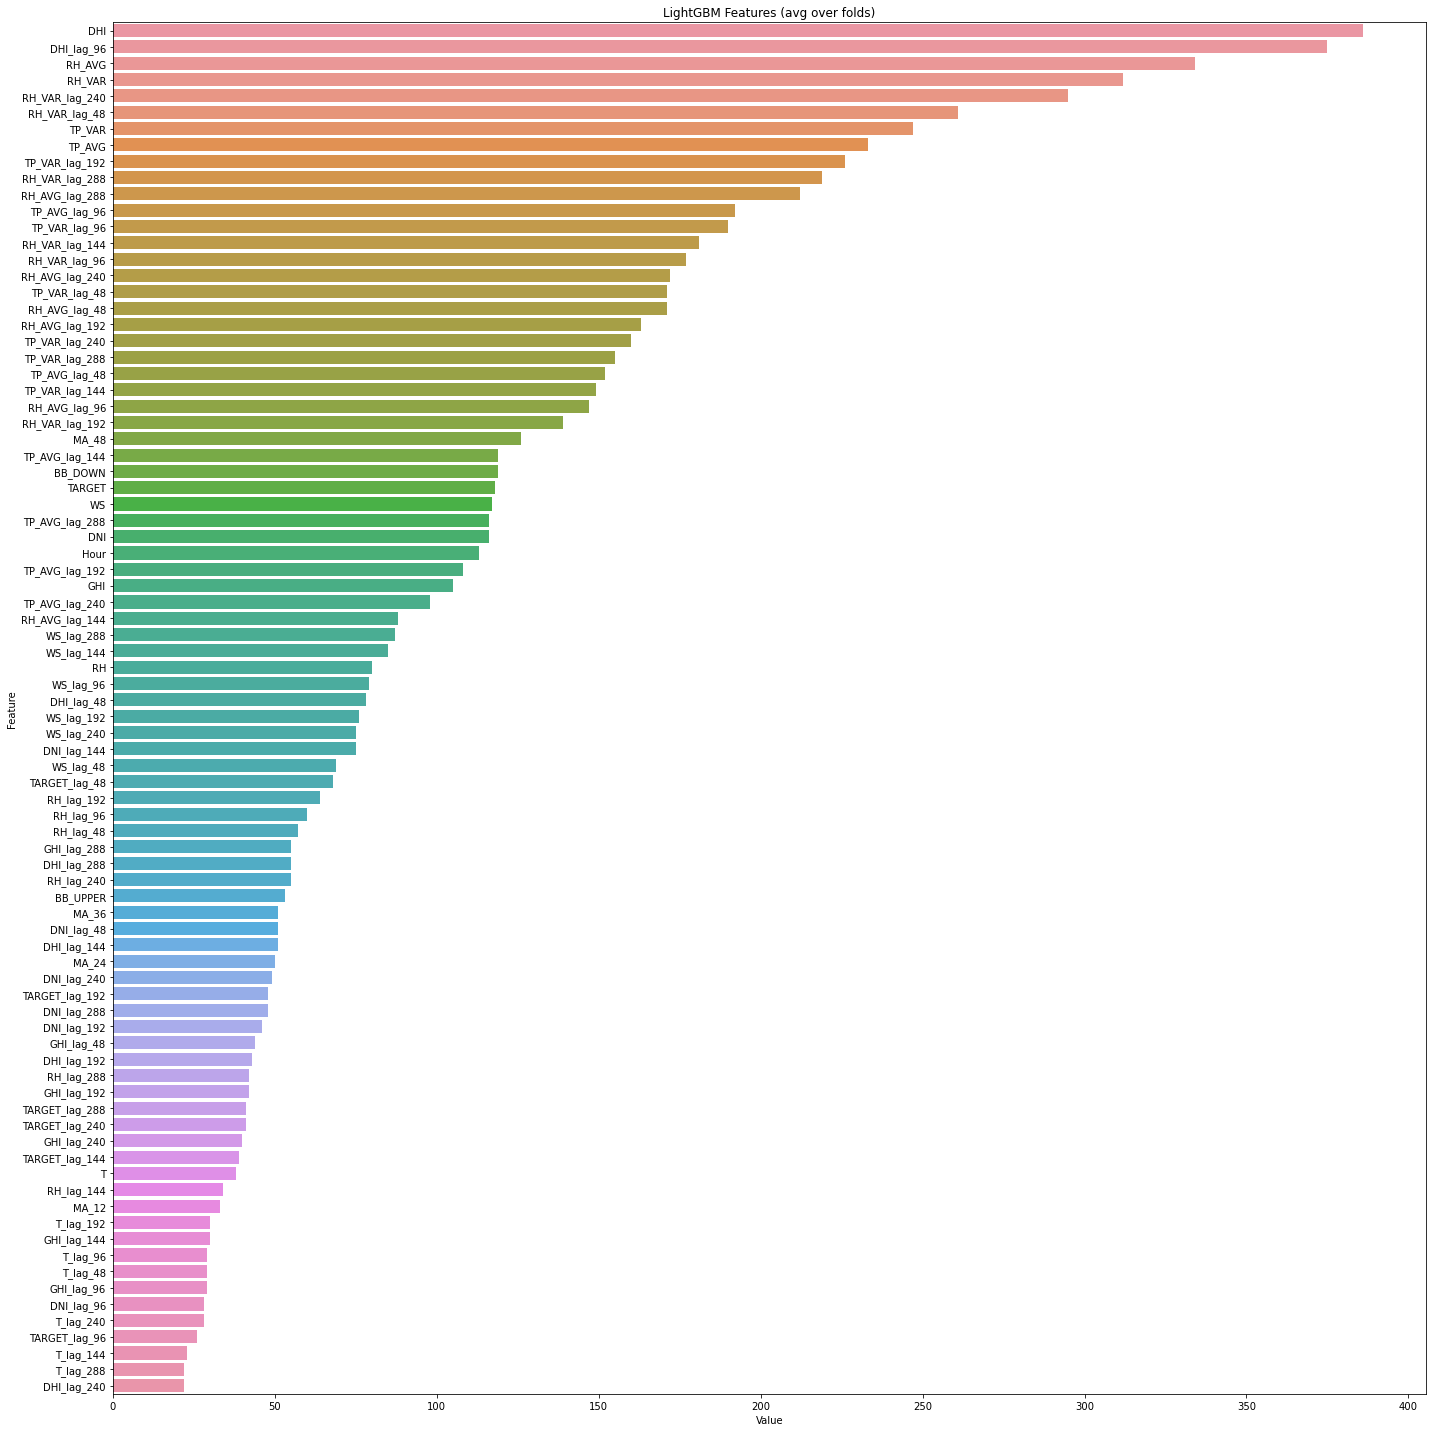

<Figure size 432x288 with 0 Axes>

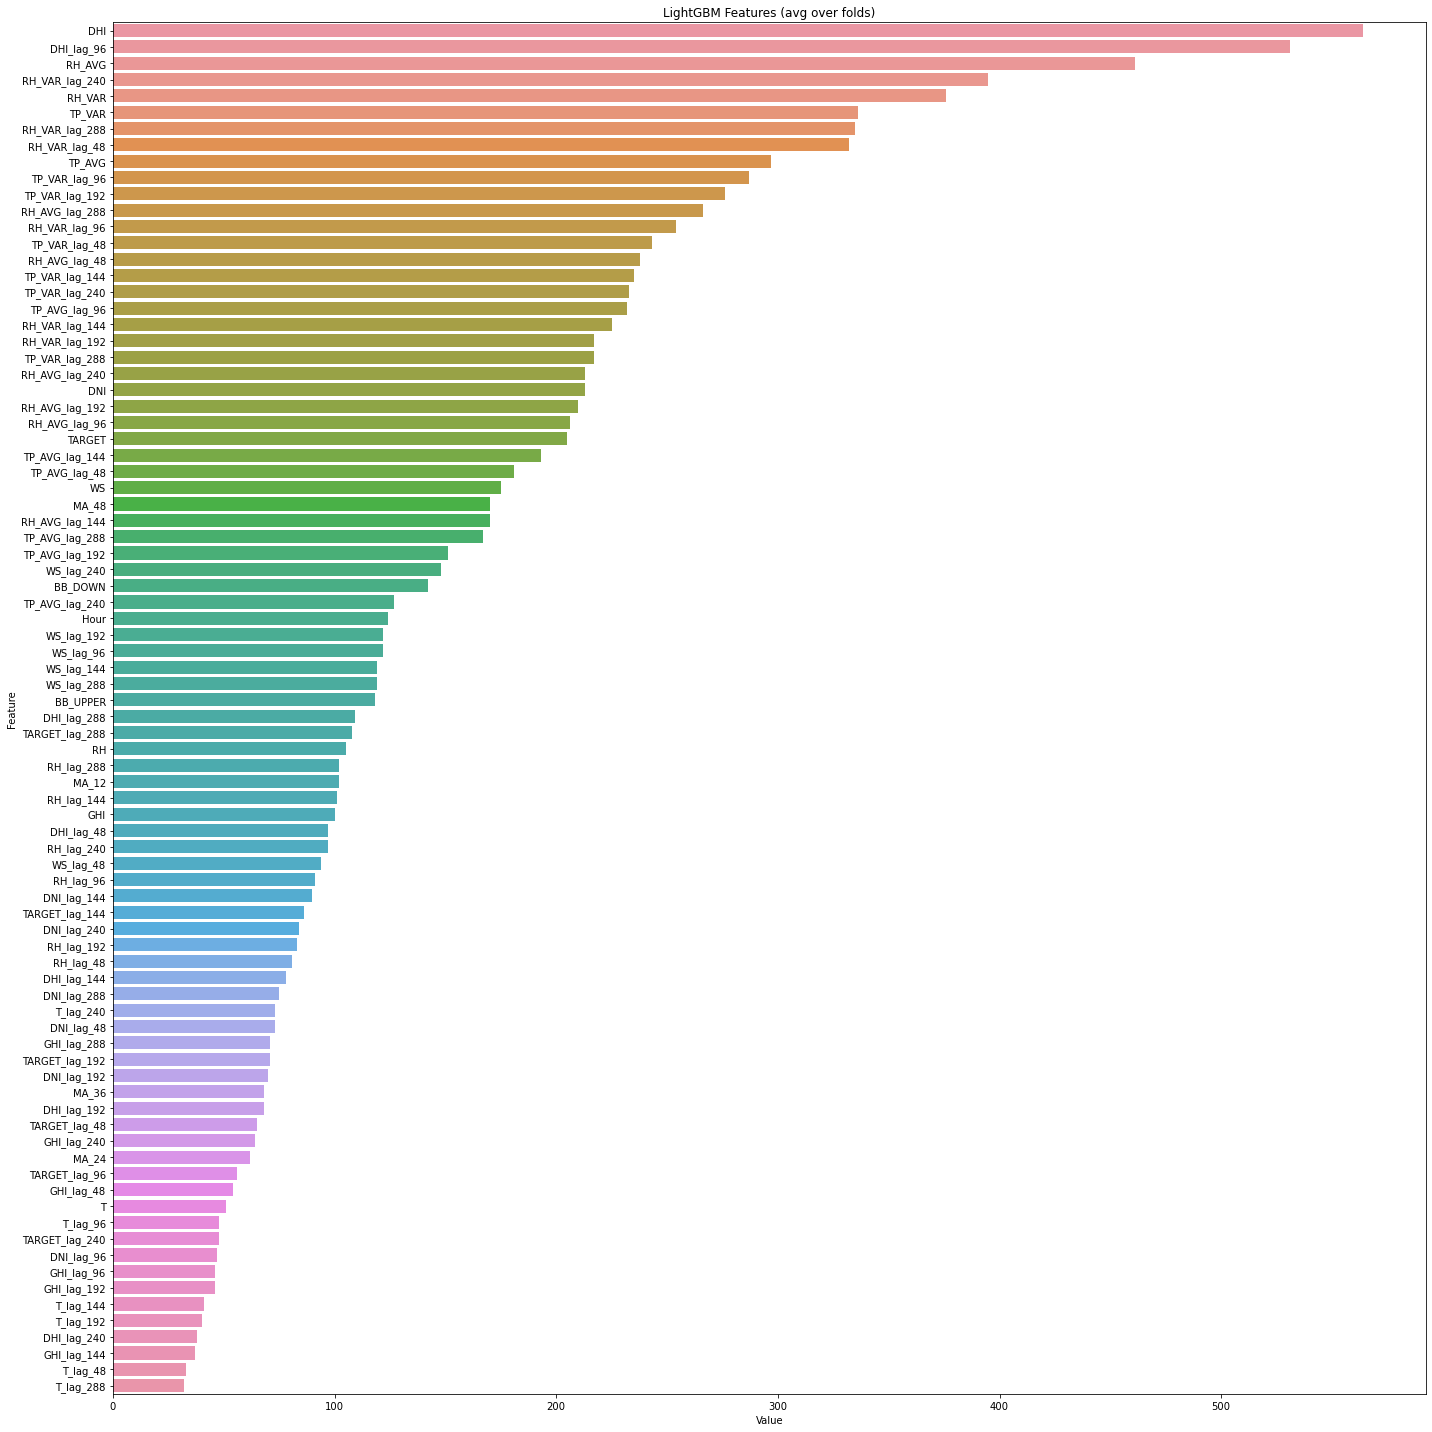

<Figure size 432x288 with 0 Axes>

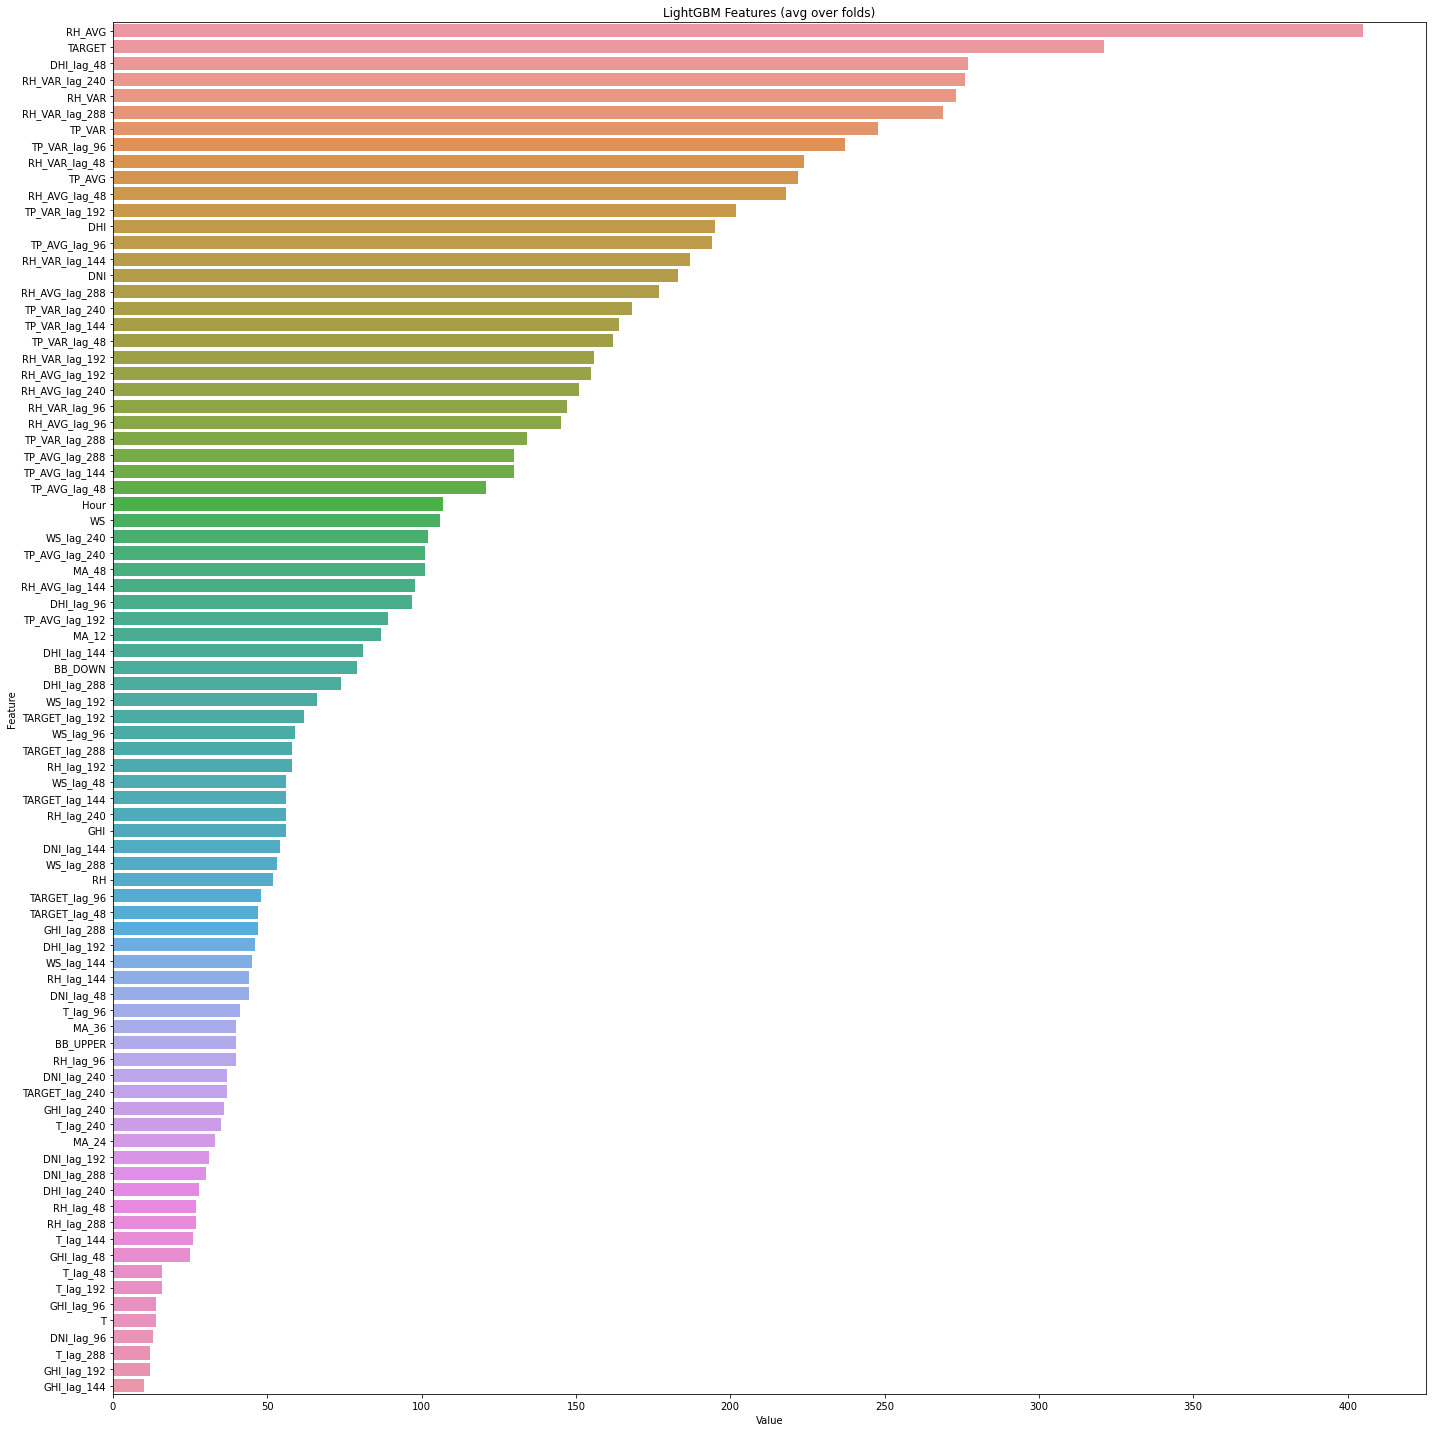

<Figure size 432x288 with 0 Axes>

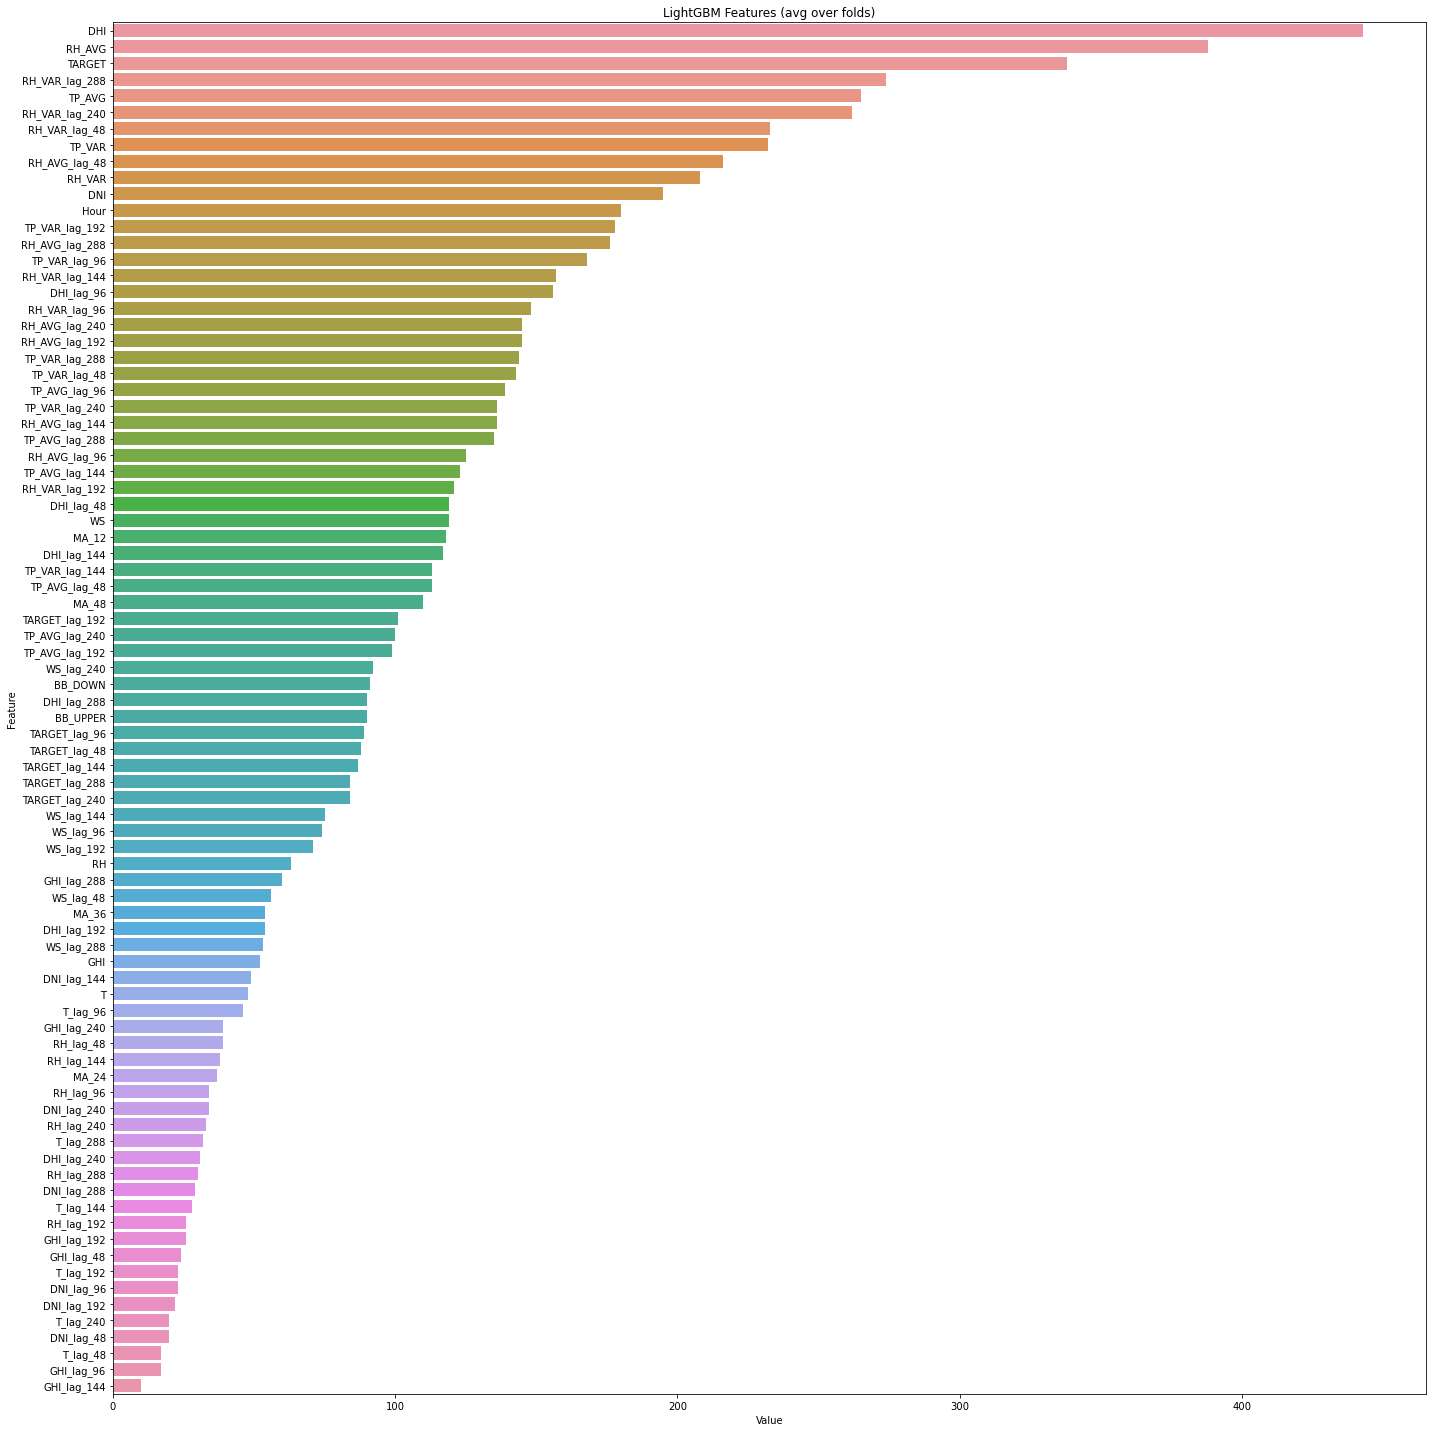

<Figure size 432x288 with 0 Axes>

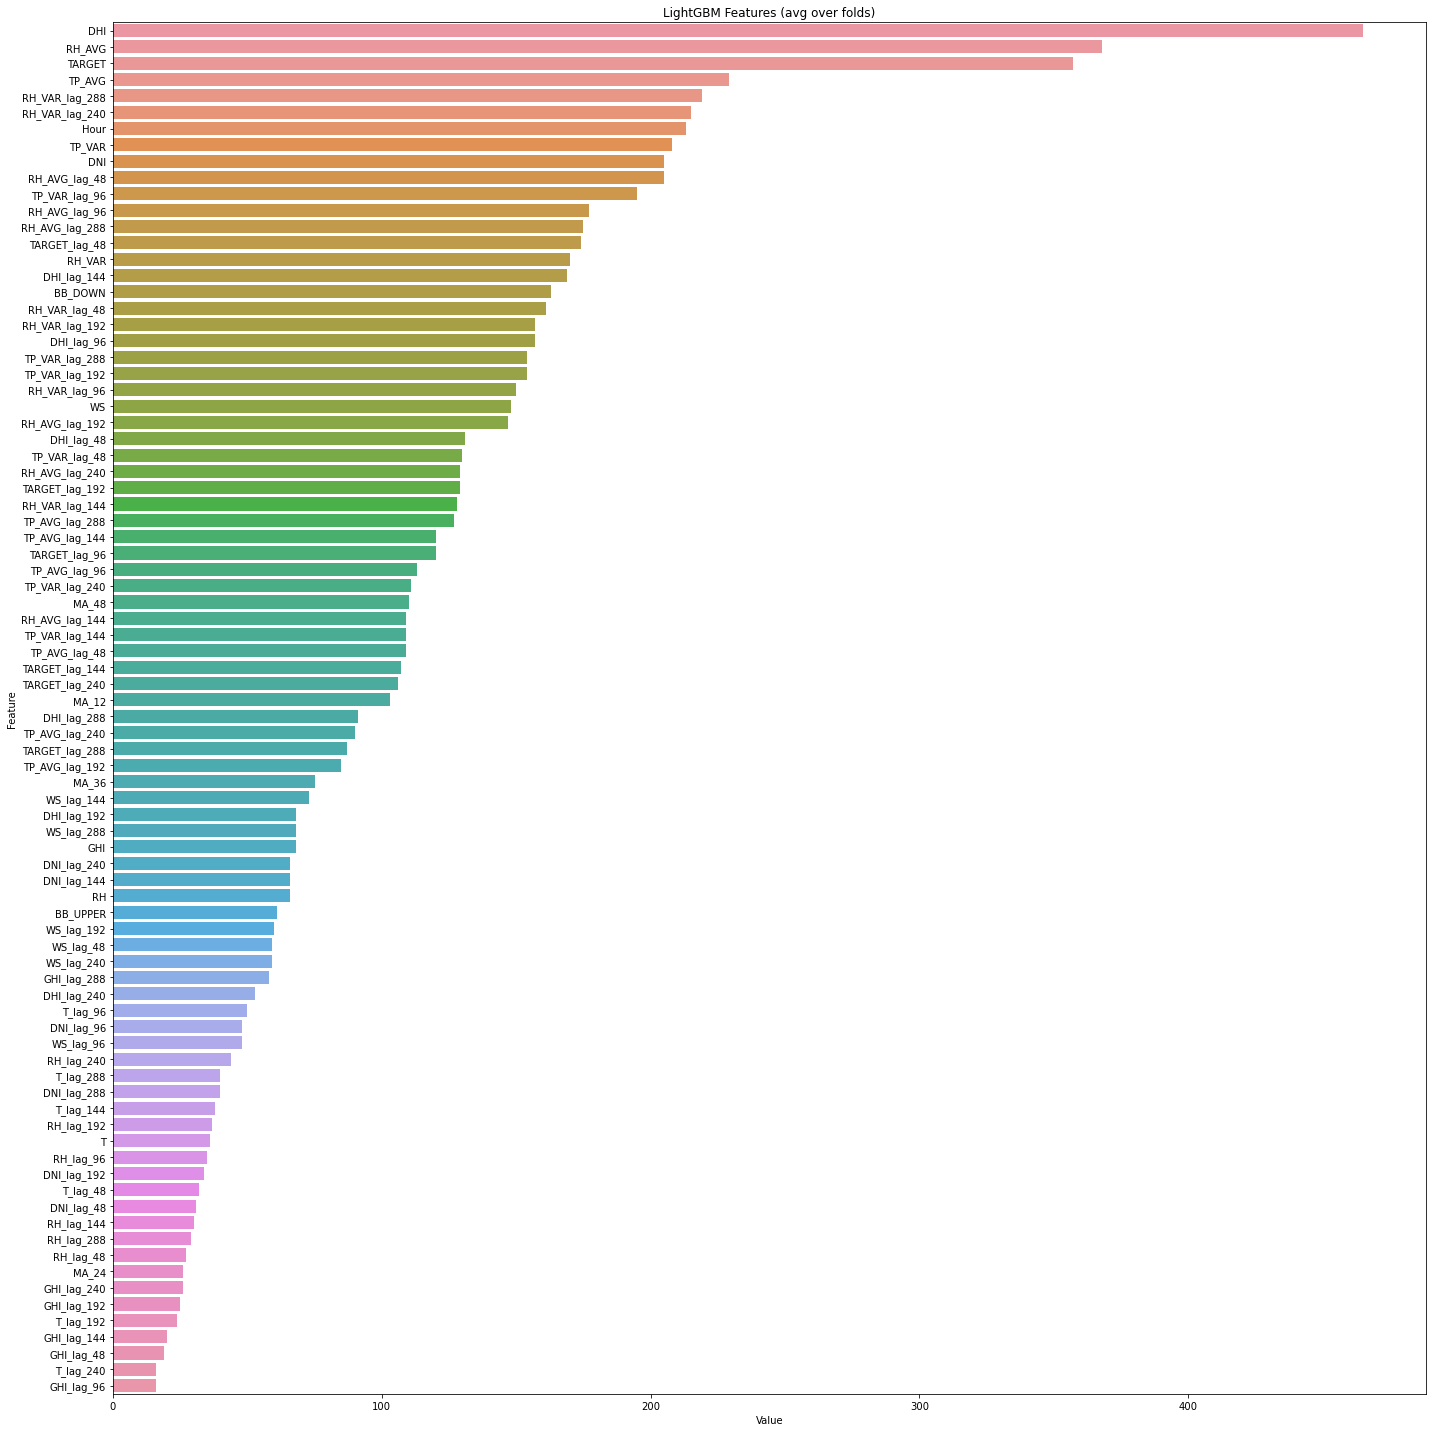

<Figure size 432x288 with 0 Axes>

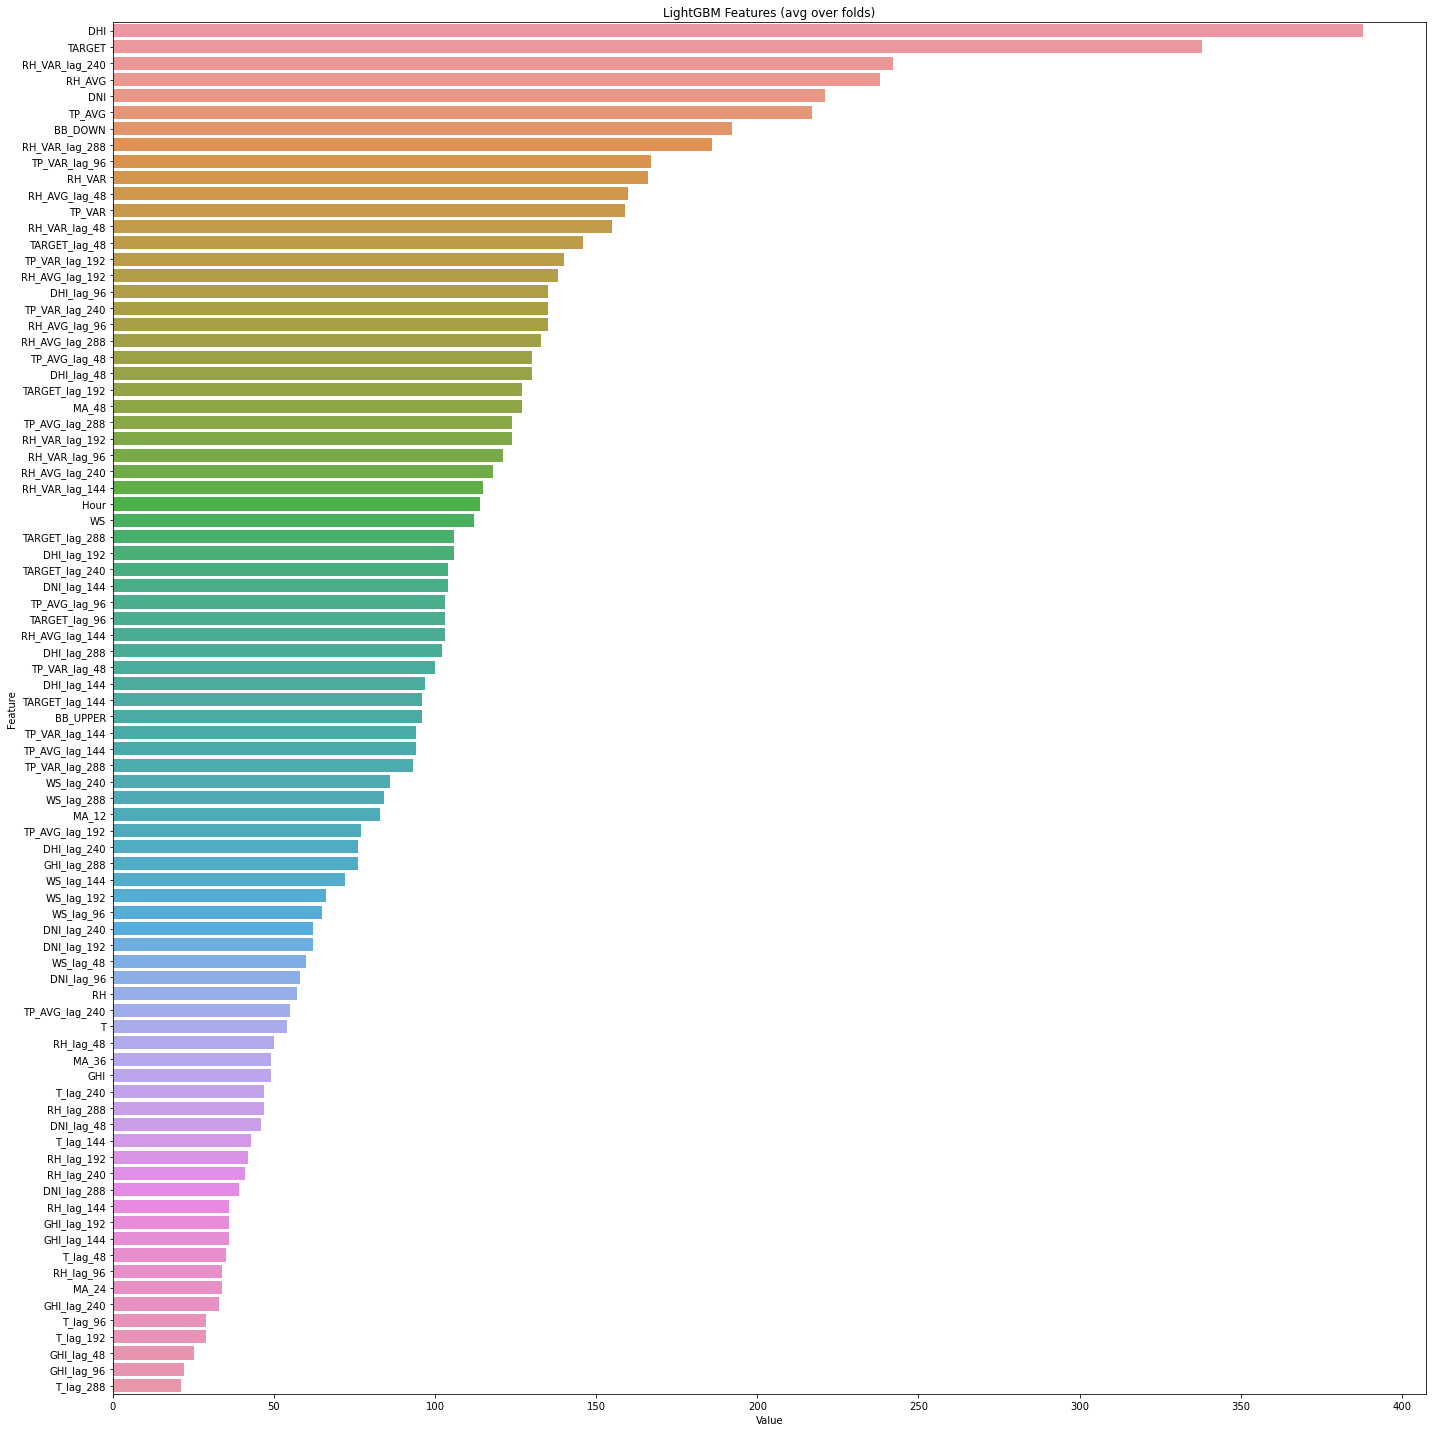

<Figure size 432x288 with 0 Axes>

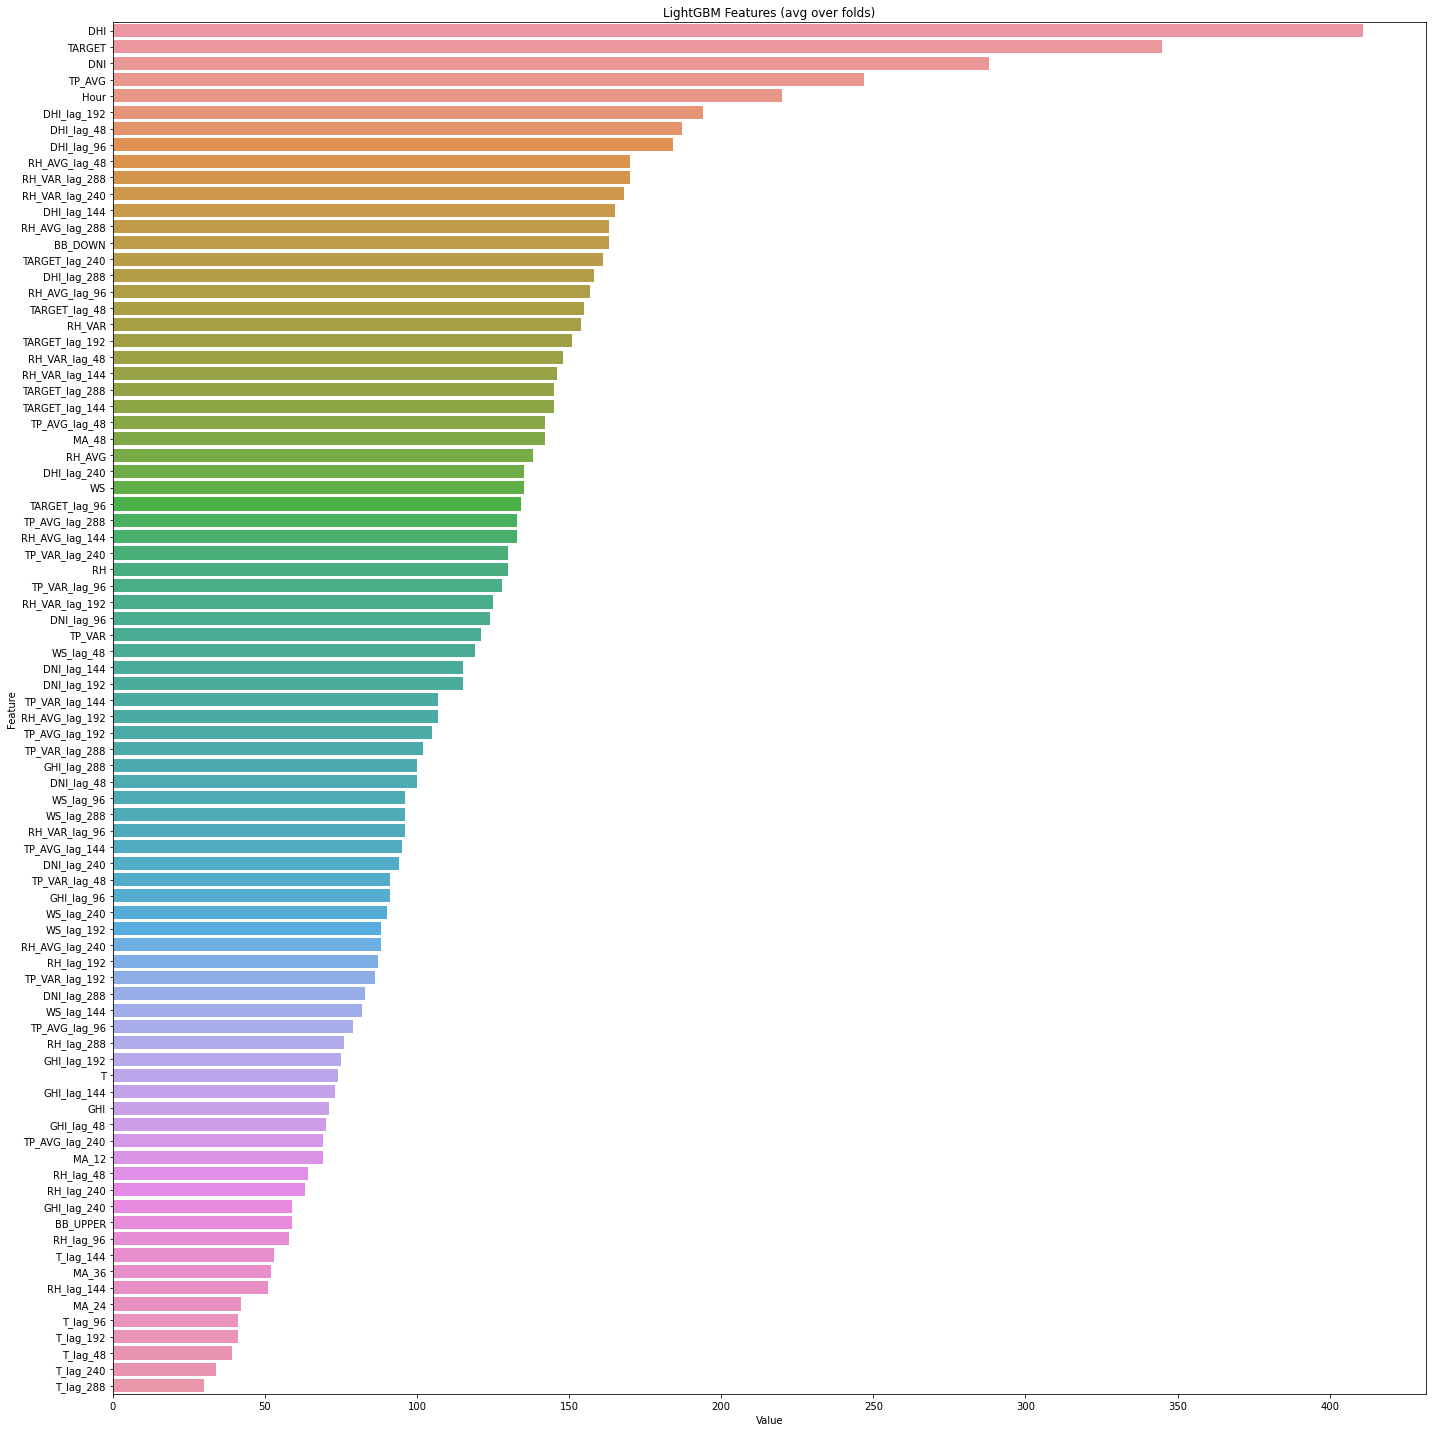

<Figure size 432x288 with 0 Axes>

In [208]:
for i in range(len(models_1)):
    # sorted(zip(clf.feature_importances_, X.columns), reverse=True)
    feature_imp = pd.DataFrame(sorted(zip(models_1[i].feature_importances_,x_train.columns)),
                               columns=['Value','Feature'])

    plt.figure(figsize=(20, 20))
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.show()
    plt.savefig('lgbm_importances-01.png')

In [211]:
# lag model 3 window decross model

submission.loc[submission.id.str.contains("Day7"), "q_0.1":] = results_1.sort_index().values
submission.loc[submission.id.str.contains("Day8"), "q_0.1":] = results_2.sort_index().values
submission[16:33]

#submission.to_csv('./submission/submission_210103-3_re-shiftedModel-MABB.csv', index=False)

,id,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
16,0.csv_Day7_8h00m,2.75,2.80,2.55,3.04,2.98,4.85,4.80,6.68,8.64
17,0.csv_Day7_8h30m,4.86,5.23,6.53,7.04,8.90,10.38,13.24,11.19,16.78
18,0.csv_Day7_9h00m,4.92,5.85,8.58,10.94,13.09,15.78,20.42,20.25,22.97
19,0.csv_Day7_9h30m,6.18,9.24,10.71,17.38,17.47,17.58,23.52,23.86,32.90
20,0.csv_Day7_10h00m,8.22,12.14,15.03,16.33,19.30,20.25,27.01,30.01,35.88
21,0.csv_Day7_10h30m,10.08,15.36,18.18,19.83,22.61,27.11,32.15,36.65,37.86
22,0.csv_Day7_11h00m,11.28,18.63,24.87,28.83,32.79,34.76,35.76,38.74,43.68
23,0.csv_Day7_11h30m,12.36,17.81,24.79,29.70,34.29,36.40,36.66,41.22,45.60
24,0.csv_Day7_12h00m,13.21,19.27,24.87,28.61,34.04,39.32,37.66,43.19,45.24
25,0.csv_Day7_12h30m,13.36,21.84,25.85,29.18,37.28,42.16,40.58,42.32,44.91


## 추가 아이디어

디콤포지션을 통해서 중요 변수에 대한 파생변수(Trend, Seasonality, cycle, residual)를 추가해보겠습니다. 이게 효과가 있을지는 모르겠습니다. TARGET, DHI...정도면 되려나?! 일단 TARGET 부터 해보죠.

In [275]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [276]:
result = seasonal_decompose(train.TARGET, model='additive', freq=4380)

In [277]:
def plot_decompose(decomposeresult):
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, figsize=(16,10))
    decomposeresult.observed.plot(legend=False, ax=ax1)
    ax1.set_ylabel('Observerd')
    decomposeresult.trend.plot(legend=False, ax=ax2)
    ax2.set_ylabel('Trend')
    decomposeresult.seasonal.plot(legend=False, ax=ax3)
    ax3.set_ylabel('Seasonal')
    decomposeresult.resid.plot(legend=False, ax=ax4)
    ax4.set_ylabel('Residual')

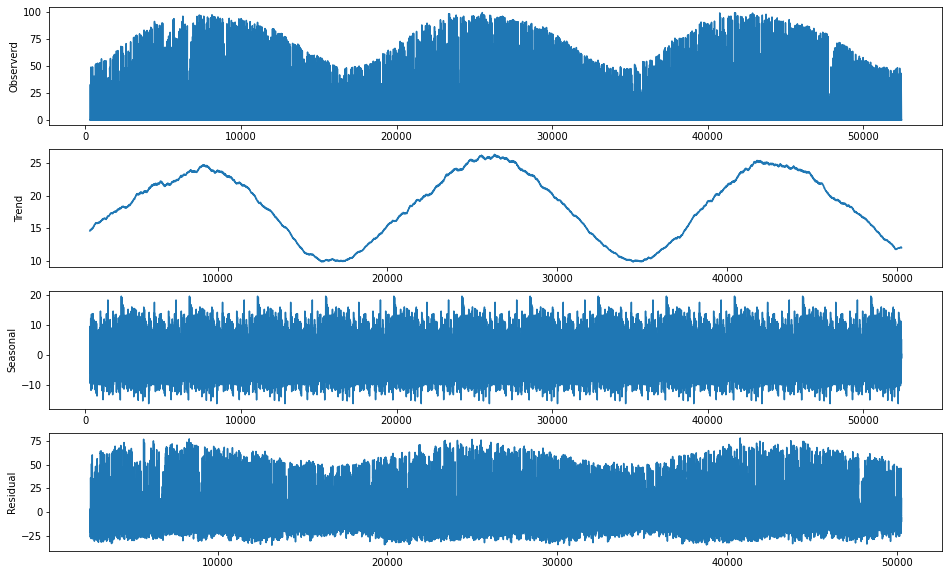

In [278]:
plot_decompose(result)